# Content

[Dependencies](#Dependencies)

[1. Dataset](#1.-Dataset)

[2. Baseline](#2.-Baseline)  
[2.1. Train test data](#2.1.-Train-test-data)  
[2.2. Model](#2.2.-Model)

[3. Upgrades](#3.-Upgrades)  
[3.1. Число рекомендаций меньше N](#3.1.-%D0%A7%D0%B8%D1%81%D0%BB%D0%BE-%D1%80%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%86%D0%B8%D0%B9-%D0%BC%D0%B5%D0%BD%D1%8C%D1%88%D0%B5-N)  
$\quad$[Рекомендация популярного](#%D0%A0%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%86%D0%B8%D1%8F-%D0%BF%D0%BE%D0%BF%D1%83%D0%BB%D1%8F%D1%80%D0%BD%D0%BE%D0%B3%D0%BE)

[3.2. Другие способы измерения близости пользователей](#3.2.-%D0%94%D1%80%D1%83%D0%B3%D0%B8%D0%B5-%D1%81%D0%BF%D0%BE%D1%81%D0%BE%D0%B1%D1%8B-%D0%B8%D0%B7%D0%BC%D0%B5%D1%80%D0%B5%D0%BD%D0%B8%D1%8F-%D0%B1%D0%BB%D0%B8%D0%B7%D0%BE%D1%81%D1%82%D0%B8-%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D0%B5%D0%B9)  
$\quad$[Кластеризация клиентов (Блендинг)](#%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F-%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2-(%D0%91%D0%BB%D0%B5%D0%BD%D0%B4%D0%B8%D0%BD%D0%B3))  
$\quad$[Предобработка признаков](#%D0%9F%D1%80%D0%B5%D0%B4%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%B2)  
$\quad$[Заполнение пропущенных значений](#%D0%97%D0%B0%D0%BF%D0%BE%D0%BB%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BF%D1%80%D0%BE%D0%BF%D1%83%D1%89%D0%B5%D0%BD%D0%BD%D1%8B%D1%85-%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D0%B9)  
$\quad$[Кластеризация](#%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F)  
$\quad$[Реализация модели по сегментам](#%D0%A0%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%BF%D0%BE-%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D0%BC)  
$\quad$[Тестирование моделей по сегментам](#%D0%A2%D0%B5%D1%81%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9-%D0%BF%D0%BE-%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D0%BC)  
[3.3. Сегментирование пользователей, которых нет в users](#3.3.-%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5-%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D0%B5%D0%B9,-%D0%BA%D0%BE%D1%82%D0%BE%D1%80%D1%8B%D1%85-%D0%BD%D0%B5%D1%82-%D0%B2-users)  
$\quad$[Feature engineering](#Feature-engineering)  
$\quad$[kNN с дополнением популярным](#kNN-%D1%81-%D0%B4%D0%BE%D0%BF%D0%BE%D0%BB%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC-%D0%BF%D0%BE%D0%BF%D1%83%D0%BB%D1%8F%D1%80%D0%BD%D1%8B%D0%BC_)  
[3.4. Популярное](#3.4.-%D0%9F%D0%BE%D0%BF%D1%83%D0%BB%D1%8F%D1%80%D0%BD%D0%BE%D0%B5)  
[3.5. Подбор гиперпараметров](#3.5.-%D0%9F%D0%BE%D0%B4%D0%B1%D0%BE%D1%80-%D0%B3%D0%B8%D0%BF%D0%B5%D1%80%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%BE%D0%B2)

[4. Оптимизация модели для одного пользователя](#4.-%D0%9E%D0%BF%D1%82%D0%B8%D0%BC%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%B4%D0%BB%D1%8F-%D0%BE%D0%B4%D0%BD%D0%BE%D0%B3%D0%BE-%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8F)

[5. Резюме](#%D0%A0%D0%B5%D0%B7%D1%8E%D0%BC%D0%B5)

# Dependencies

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import dill
from implicit.nearest_neighbours import CosineRecommender,\
                                        TFIDFRecommender
import warnings
warnings.filterwarnings("ignore")

from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import MAP, calc_metrics

from userknn import UserKnn

from implicit.nearest_neighbours import ItemItemRecommender

# 1. Dataset

In [2]:
interactions = pd.read_csv('kion_train/interactions.csv')
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')

In [3]:
# rename columns, convert timestamp
interactions.rename(columns={'last_watch_dt': Columns.Datetime,
                            'total_dur': Columns.Weight}, 
                    inplace=True) 

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

In [4]:
pd.concat([interactions.head(1), interactions.tail(1)])

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
5476250,319709,4436,2021-08-15,3921,45.0


In [5]:
pd.concat([users.head(1), users.tail(1)])

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
840196,166555,age_65_inf,income_20_40,Ж,0


In [6]:
pd.concat([items.head(1), items.tail(1)])

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
15962,3206,series,Гоша,NaN,2019.0,комедии,Россия,0.0,16.0,NaN,Михаил Миронов,"Мкртыч Арзуманян, Виктория Рунцова","Добродушный Гоша не может выйти из дома, чтобы...","Гоша, 2019, Россия"


# 2. Baseline

## 2.1. Train test data

По соображениям производительности предварительные тесты моделей будем проводить на следующих данных:

In [7]:
# train test split 
# test = last 1 week 
from rectools.model_selection import TimeRangeSplitter
from rectools.dataset.interactions import Interactions


n_folds = 1
unit = "W"
n_units = 1
periods = n_folds + 1
freq = f"{n_units}{unit}"

last_date = interactions[Columns.Datetime].max().normalize()
start_date = last_date - pd.Timedelta(n_folds * n_units + 1, unit=unit)  
print(f"Start date and last date of the test fold: {start_date, last_date}")
    
date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)
print(f"Test fold borders: {date_range.values.astype('datetime64[D]')}")

# generator of folds
cv = TimeRangeSplitter(
    date_range=date_range,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)

interactions_s = Interactions(interactions)
print(f"Real number of folds: {cv.get_n_splits(interactions_s)}")

Start date and last date of the test fold: (Timestamp('2021-08-08 00:00:00'), Timestamp('2021-08-22 00:00:00'))
Test fold borders: ['2021-08-08' '2021-08-15']
Real number of folds: 1


In [8]:
# we have just 1 test fold - no need to iterate over fold
(train_ids, test_ids, fold_info) = cv.split(
    interactions_s, collect_fold_stats=True).__next__()

In [9]:
train_ids

array([      0,       1,       2, ..., 5476245, 5476247, 5476249])

In [10]:
test_ids

array([      6,      33,      56, ..., 5476229, 5476230, 5476240])

In [11]:
train = interactions.loc[train_ids]
test = interactions.loc[test_ids]

## 2.2. Model

In [16]:
# base knn
with open('base_userknn.dill', 'rb') as f:
    userknn = dill.load(f)

base_userknn = UserKnn(userknn)
base_userknn.is_fitted = True
base_userknn.fit(train)

In [13]:
recos = base_userknn.predict(test)

In [14]:
catalog = train[Columns.Item].unique()

In [12]:
metric = MAP(k=10)

In [16]:
metric.calc(recos, test)

0.0022360789388995196

# 3. Upgrades

## 3.1. Число рекомендаций меньше N

Такая ситуация может возникнуть, если похожие пользователи смотрят одни и те же фильмы и в небольшом количестве. В настолько небольшом, что при их объединении мы получаем количество фильмов < N.

Варианты исправить:

1) Рекомендовать таким пользователям популярное как дополнительные айтемы

Такой вариант кажется разумным. Мы имеем дело с теплыми пользователями, которые что-то смотрели, которым можно что-то подобрать и скорее всего достаточно релевантное. Остальные айтемы вполне могут быть просто популярным.

2) Увеличивать количество соседей для таких пользователей до тех пор, пока не наберется необходимое количество рекомендаций.

Вопрос: с каким шагом перебирать количество соседей? Если цикл будет слишком долго искать необходимое количество соседей, то вычисления могут затянуться. Также с ростом количества соседей растет и количество необходимых вычислений.

### Рекомендация популярного

In [17]:
# Модель популярного
_, bins = pd.qcut(items["release_year"], 10, retbins=True)
labels = bins[:-1]

year_feature = pd.DataFrame(
    {
        "id": items["item_id"],
        "value": pd.cut(items["release_year"], bins=bins, labels=bins[:-1]),
        "feature": "release_year",
    }
)
year_feature.head()


items["genre"] = items["genres"].str.split(",")
items[["genre", "genres"]].head(3)


genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()


item_feat = pd.concat([genre_feature, year_feature])
item_feat = item_feat[item_feat['id'].isin(interactions['item_id'])]


dataset = Dataset.construct(
    interactions_df=interactions,
    user_features_df=None,
    item_features_df=item_feat,  # item_id, value, feature_name
    cat_item_features=['genre', 'release_year']  # pre processed features names
)


from rectools.models.popular import PopularModel 

pop = PopularModel()
pop.fit(dataset);

In [18]:
items_pop_ordered = pop.recommend(
    dataset.user_id_map.external_ids[:1],
    dataset=dataset,
    k=items.shape[0],
    filter_viewed=False
)['item_id']

In [13]:
with open('items_pop_ordered.dill', 'rb') as f:
    items_pop_ordered = dill.load(f)

In [14]:
class UserKnnComplete(UserKnn):
    def __init__(
        self,
        model: ItemItemRecommender,
        pop_items: np.array,
        N_users: int = 50,
    ):
        super().__init__(model, N_users)
        self.pop_items = pop_items
    
    def complete_items_with_pop(
        self,
        all_recs: pd.DataFrame,
        users_ids: np.array,
        N: int
    ) -> pd.DataFrame:
        """Returns completed with pop recs."""
        add_pop = pd.DataFrame({
            'user_id': np.repeat(users_ids, N),
            'item_id': np.tile(self.pop_items[:N], users_ids.shape),
            'score': [0] * users_ids.shape[0]*N
        })
        cols = ['user_id', 'item_id', 'score']
        complete_users_mask = all_recs['user_id'].isin(users_ids)
        recs_add_pop = pd.concat([
            # exclude duplicates in new items:
            pd.concat([
                add_pop,
                all_recs[complete_users_mask][cols]
            ]).drop_duplicates(['user_id', 'item_id'], keep='first'),
            # concatenate with another recs:
            all_recs[~complete_users_mask][cols]
        ])
        return recs_add_pop
    
    def predict(
        self,
        test: pd.DataFrame,
        N_recs: int = 10,
        complete_method: str = 'no_complete'
    ) -> pd.DataFrame:
        
        if not self.is_fitted:
            raise ValueError("Please call fit before predict")
        
        mapper = self._generate_recs_mapper(
            model=self.user_knn, 
            user_mapping=self.users_mapping,
            user_inv_mapping=self.users_inv_mapping,
            N=self.N_users
        )

        recs = pd.DataFrame({'user_id': test['user_id'].unique()})
        recs['sim_user_id'], recs['sim'] = zip(*recs['user_id'].map(mapper))
        recs = recs.set_index('user_id').apply(pd.Series.explode).reset_index()
        
        recs = recs[~(recs['sim'] >= 1)]\
            .merge(self.watched, left_on=['sim_user_id'], right_on=['user_id'], how='left')\
            .explode('item_id')\
            .sort_values(['user_id', 'sim'], ascending=False)\
            .drop_duplicates(['user_id', 'item_id'], keep='first')\
            .merge(self.item_idf, left_on='item_id', right_on='index', how='left')
        
        recs['score'] = recs['sim'] * recs['idf']
        
        # find users with less than N items:
        count_recs = recs.groupby('user_id').count().reset_index()
        users_to_complete = np.concatenate([
            count_recs[  # users with less than N recs
                count_recs['item_id'] < N_recs
            ]['user_id'].values,
            test[  # users with no recs at all
                ~test['user_id'].isin(recs['user_id'])
            ]['user_id'].values
        ])
        
        # complete them with N_recs items:
        # (N_recs - items_count) is needed to complete to N_recs
        # but (+ items_count) to exclude duplicates in the future
        if users_to_complete.any():
            if complete_method == 'popular':
                recs = self.complete_items_with_pop(
                    recs, users_to_complete, N_recs)
            else:
                print(f'Unknown complete method: {complete_method}')

        recs = recs.sort_values(['user_id', 'score'], ascending=False)
        recs['rank'] = recs.groupby('user_id').cumcount() + 1
        return recs[recs['rank'] <= N_recs][['user_id', 'item_id', 'score', 'rank']]

In [19]:
pop_userknn = UserKnnComplete(userknn, items_pop_ordered)
pop_userknn.is_fitted = True
pop_userknn.fit(train)

In [20]:
knn_pop_recs = pop_userknn.predict(
    test, complete_method='popular')

In [21]:
knn_pop_recs = pd.concat([
    pop_userknn.predict(test.iloc[:69174], complete_method='popular'),
    pop_userknn.predict(test.iloc[69174:138349], complete_method='popular'),
    pop_userknn.predict(test.iloc[138349:207524], complete_method='popular'),
    pop_userknn.predict(test.iloc[207524:], complete_method='popular')
])

In [22]:
metric.calc(knn_pop_recs, test)

0.028634398574155298

## 3.2. Другие способы измерения близости пользователей

### Кластеризация клиентов (Блендинг)

Можно уточнить модели, обучив каждую работать в своем сегменте пользователей (это также ограничивает и сегмент айтемов). Очевидно, что скорее всего в среднем женщинам будут нравится немного другие фильмы, нежели мужчинам.

Кластерные структуры можно по-разному усложнять.

К исходным признакам можно добавлять признаки из истории: просмотренные фильмы, количество фильмов, время просмотра, кино/сериалы, прочее.

In [23]:
pd.concat([users.head(1), users.tail(1)])

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
840196,166555,age_65_inf,income_20_40,Ж,0


Чем менее очевидно разбиение на кластеры, тем скорее нужно смотреть, например, на среднее межкластерное расстояние или что-нибудь, что позволяет оценить, насколько большой вклад внесло очередное разбиение. Для этого нужно уметь вычилсять расстояние между юзерами - можно опять использовать расстояние на основе просмотренных фильмов. Однако не факт, что предложенный вариант хорошо разобъет клиентов на сегменты. При любом разбиении всегда можно оценить качество итоговой модели рекомендации, такой вариант даже лучше с точки зрения подбора алгоритма кластеризации.

    Важно выбирать подход к кластеризации и к заполнению пропусков основываясь на метриках качества целевой задачи - построение рекомендаций, так как не всегда наилучшее решение подзадачи коррелирует с наилучшим решением основной задачи.

Наилучший предикат для разбиения на кластеры нужно искать последовательно, на каждом шаге перебирая все разбиения, чтобы найти наиболее информативное в соотвтесвии с выбранным критерием.

**Количество разбиений также является гиперпараметром**

Лучше сразу начать с наиболее очевидных предикатов:

1. Пол
2. Дети
3. Возвраст
4. Доход

По итогу удобно будет представить разбиение юзеров на сегменты с помощью датафрейма со столбцами `user_id`, `segment`. Далее уже вытаскивать для каждой модели необходимых пользователей.

In [24]:
# Можно ограничить число возрастных группы до трех
set(users['age'])

{'age_18_24',
 'age_25_34',
 'age_35_44',
 'age_45_54',
 'age_55_64',
 'age_65_inf',
 nan}

In [25]:
# Уровни дохода также можно ограничить до трех
set(users['income'])

{'income_0_20',
 'income_150_inf',
 'income_20_40',
 'income_40_60',
 'income_60_90',
 'income_90_150',
 nan}

### Предобработка признаков

Посомтрим, сколько в данных неизвестных значений:

In [26]:
print(users.shape)
users.info()

(840197, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       826102 non-null  object
 2   income    825421 non-null  object
 3   sex       826366 non-null  object
 4   kids_flg  840197 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 32.1+ MB


Пол, доход и возраст имеют пустые значения. Их можно попробовать заполнить, однако начнем с преобразования имеющихся признаков. Заменим интервалы на соответсвующие средние значения в признаках возраста и дохода. Пол заменим на $\{0, 1\}$:

In [27]:
pd.concat([users.head(2), users.tail(2)])

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
840195,590706,NaN,NaN,Ж,0
840196,166555,age_65_inf,income_20_40,Ж,0


In [28]:
def feature_to_mean_map(unique_values) -> dict:
    res = {np.nan: np.nan}
    for feature_val in unique_values:
        if isinstance(feature_val, str):
            vals = [int(i) if i != 'inf' else 74
             for i in feature_val.split('_')[1:]]
            res[feature_val] = np.mean(vals)
    return res

In [29]:
users_segment = users.copy()

In [30]:
age_map = feature_to_mean_map(users_segment['age'].unique())
# age_map

In [31]:
income_map = feature_to_mean_map(users_segment['income'].unique())
# income_map

In [32]:
users_segment['sex'].unique()

array(['М', 'Ж', nan], dtype=object)

In [33]:
sex_map = {'М': 0, 'Ж': 1, np.nan: np.nan}

In [34]:
users_segment['age'] = users_segment['age'].map(age_map.get)
users_segment['income'] = users_segment['income'].map(income_map.get)
users_segment['sex'] = users_segment['sex'].map(sex_map.get)

In [35]:
pd.concat([users_segment.head(2), users_segment.tail(2)])

,user_id,age,income,sex,kids_flg
0,973171,29.5,75.0,0.0,1
1,962099,21.0,30.0,0.0,0
840195,590706,NaN,NaN,1.0,0
840196,166555,69.5,30.0,1.0,0


In [36]:
users_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   840197 non-null  int64  
 1   age       826102 non-null  float64
 2   income    825421 non-null  float64
 3   sex       826366 non-null  float64
 4   kids_flg  840197 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 32.1 MB


### Заполнение пропущенных значений

Можно рассмотреть несколько мыслей.

Во-первых можно вообще не заполнять пропуски и рассматривать только пользователей, у которых нет пропусков в нужных нам признаках. Соответственно пользователей с пропусками можно убрать из тренировочной выборки вообще и считать их холодными пользователями. Однако так мы теряем скорее всего ощутимую часть информации о холодных пользователей.

С другой стороны можно рассмотреть всех пользователей с пропущенными значениями как отдельный сегмент и отдельно для них обучать модель рекомендаций.

Но также можно попытаться заполнить пропуски по необходимым нам признакам и посомтреть на качество модели рекомендации. Пока что сконцентрируемся на заполнении пропусков.

Количество пропущенных значений:

In [37]:
print(users_segment.shape)
users_segment.isna().sum(axis=0)

(840197, 5)


user_id         0
age         14095
income      14776
sex         13831
kids_flg        0
dtype: int64

Для заполнения пропусков воспользуемся подходом MissForest.

Библиотека с реализацией: https://pypi.org/project/missingpy/

In [38]:
from missingpy import MissForest

In [39]:
miss_forest = MissForest(max_iter=6)

In [40]:
cols = ['age', 'income', 'sex', 'kids_flg']
users_segment_filled = miss_forest.fit_transform(
    users_segment[cols])

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [41]:
users_segment_filled_df = pd.DataFrame(
    users_segment_filled,
    columns=cols,
    index=users_segment.index
)
users_segment_filled_df['user_id'] = users_segment['user_id']
users_segment_filled_df = users_segment_filled_df[
    users_segment.columns]

In [42]:
# before na filling:
users_segment.tail(2)

,user_id,age,income,sex,kids_flg
840195,590706,NaN,NaN,1.0,0
840196,166555,69.5,30.0,1.0,0


In [43]:
# after na filling:
users_segment_filled_df.tail(2)

,user_id,age,income,sex,kids_flg
840195,590706,49.5,40.198773,1.0,0.0
840196,166555,69.5,30.000000,1.0,0.0


In [44]:
print(users_segment_filled_df.shape)
users_segment_filled_df.info()

(840197, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   840197 non-null  int64  
 1   age       840197 non-null  float64
 2   income    840197 non-null  float64
 3   sex       840197 non-null  float64
 4   kids_flg  840197 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 32.1 MB


Проверим, сохранились ли предыдущие категории:

In [45]:
users_segment_filled_df['sex'].unique()

array([0.        , 1.        , 0.46241896, 0.65173407, 0.59491126,
       0.47173803, 0.37608274, 0.58149787, 0.5298589 , 0.52861491,
       0.51508363, 0.45645657, 0.30857165, 0.55219693, 0.59755894,
       0.31564976, 0.37660557, 0.74836553, 0.31369527, 0.3505545 ,
       0.37008799, 0.39440137, 0.52950323, 0.54451077, 0.37199646,
       0.67237343, 0.31787589, 0.52972782, 0.56084809, 0.38726723,
       0.43804325, 0.55179641, 0.3999312 , 0.37952443, 0.73891957,
       0.75819518, 0.78347494, 0.67797189, 0.50590449, 0.30731948,
       0.38372354, 0.77661788, 0.76133256, 0.75374241, 0.55096706,
       0.7591175 , 0.32486434, 0.28096716, 0.80869739, 0.30674459,
       0.40371566, 0.40745674])

Округлим полученные значения пола:

In [46]:
users_segment_filled_df['sex'] = (
    users_segment_filled_df['sex']
    .round()
    .astype(int)
)
users_segment_filled_df['kids_flg'] = (
    users_segment_filled_df['kids_flg']
    .round()
    .astype(int)
)

In [47]:
print(users_segment_filled_df['kids_flg'].unique())
print(users_segment_filled_df['sex'].unique())

[1 0]
[0 1]


Проверим года:

In [48]:
old_ages = users_segment['age'].unique()[
    ~np.isnan(users_segment['age'].unique())]
old_ages

array([29.5, 21. , 49.5, 39.5, 59.5, 69.5])

In [49]:
new_ages = users_segment_filled_df['age'].unique()[
    ~np.isin(users_segment_filled_df['age'].unique(), old_ages)]
new_ages

array([42.29876754, 38.98884365, 38.02421069, 40.039528  , 36.963616  ,
       40.80937568, 41.55691593, 38.9307105 , 38.03599369, 39.38810003,
       38.43183755, 33.36728814, 40.51763614, 33.30131349, 39.54006355,
       39.27800016, 33.65213661, 41.53885078])

Заменим данные значения на ближайшие из старых:

In [50]:
from scipy.spatial.distance import cdist

In [51]:
old_ages_for_new = old_ages[(
cdist(new_ages.reshape(-1, 1), old_ages.reshape(-1, 1))
    .argmin(axis=1)
)]
old_ages_for_new

array([39.5, 39.5, 39.5, 39.5, 39.5, 39.5, 39.5, 39.5, 39.5, 39.5, 39.5,
       29.5, 39.5, 29.5, 39.5, 39.5, 29.5, 39.5])

In [52]:
old_ages_to_new_map = {
    old: new for old, new in zip(new_ages, old_ages_for_new)
}
old_ages_to_new_map

{42.29876754224782: 39.5,
 38.98884365085: 39.5,
 38.0242106883374: 39.5,
 40.039527999773014: 39.5,
 36.963616003857474: 39.5,
 40.8093756781313: 39.5,
 41.5569159292956: 39.5,
 38.9307104960185: 39.5,
 38.03599369182699: 39.5,
 39.3881000335568: 39.5,
 38.43183754911681: 39.5,
 33.36728813721007: 29.5,
 40.51763614382563: 39.5,
 33.301313493070104: 29.5,
 39.54006354949085: 39.5,
 39.278000160800815: 39.5,
 33.65213660693381: 29.5,
 41.538850777493906: 39.5}

In [53]:
new_ages_index = users_segment_filled_df['age'][
    users_segment_filled_df['age'].isin(new_ages)].index

users_segment_filled_df.loc[new_ages_index, 'age'] =\
users_segment_filled_df['age'].loc[new_ages_index].map(
    old_ages_to_new_map.get)

In [54]:
users_segment_filled_df['age'].unique()

array([29.5, 21. , 49.5, 39.5, 59.5, 69.5])

In [55]:
(old_ages == users_segment_filled_df['age'].unique()).all()

True

Ту же операцию можно проделать и с доходом:

In [56]:
old_incomes = users_segment['income'].unique()[
    ~np.isnan(users_segment['income'].unique())]
old_incomes

array([ 75.,  30.,  50.,  10., 120., 112.])

In [57]:
new_incomes = users_segment_filled_df['income'].unique()[
    ~np.isin(
        users_segment_filled_df['income'].unique(), old_incomes)]
new_incomes

array([40.19877322, 42.42844577, 39.64524053, 34.82189178, 35.29972842,
       35.20678889, 46.5682267 , 38.85145737, 32.15124135, 38.87850996,
       46.50033217, 40.45074422])

In [58]:
old_incomes_for_new = old_incomes[(
cdist(new_incomes.reshape(-1, 1), old_incomes.reshape(-1, 1))
    .argmin(axis=1)
)]
old_incomes_for_new

array([50., 50., 30., 30., 30., 30., 50., 30., 30., 30., 50., 50.])

In [59]:
old_incomes_for_new_map = {
    old: new for old, new in zip(new_incomes, old_incomes_for_new)
}

In [60]:
new_incomes_index = users_segment_filled_df['income'][
    users_segment_filled_df['income'].isin(new_incomes)].index

users_segment_filled_df.loc[new_incomes_index, 'income'] =\
users_segment_filled_df['income'].loc[new_incomes_index].map(
    old_incomes_for_new_map.get)

In [61]:
users_segment_filled_df['income'].unique()

array([ 75.,  30.,  50.,  10., 120., 112.])

In [62]:
(old_incomes == users_segment_filled_df['income'].unique()).all()

True

Сохраним датасет с заполненными значениями:

In [63]:
users_segment_filled_df.to_csv(
    'kion_train/users_filled.csv', index=False)

In [64]:
users_segment_filled_df = pd.read_csv(
    'kion_train/users_filled.csv')

### Кластеризация

In [65]:
pd.concat([
    users_segment_filled_df.head(2),
    users_segment_filled_df.tail(2)
])

,user_id,age,income,sex,kids_flg
0,973171,29.5,75.0,0,1
1,962099,21.0,30.0,0,0
840195,590706,49.5,50.0,1,0
840196,166555,69.5,30.0,1,0


У нас уже есть два очевидных разбиения: `Пол`, `Дети`. Остальные разбиения подберем интуитивно на основе гистограм. На самом деле можно разбить вообще по всем имеющимся категориям.

<AxesSubplot:>

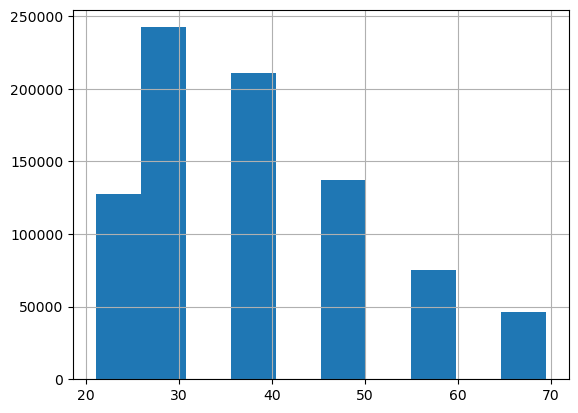

In [66]:
users_segment_filled_df['age'].hist()

Можно объединить пользователей:
* от 20 до 30 ~ 0
* от 35 до 50 ~ 1
* от 55 до 70 ~ 2

In [67]:
users_segment_final = users_segment_filled_df.copy()

In [68]:
old_ages

array([29.5, 21. , 49.5, 39.5, 59.5, 69.5])

In [69]:
users_segment_final['segm_age'] = pd.cut(
    users_segment_final['age'],
    [0, 30, 50, 80],
    labels=[0, 1, 2]
)

Тем же образом разобъем на сегменты и доход:

<AxesSubplot:>

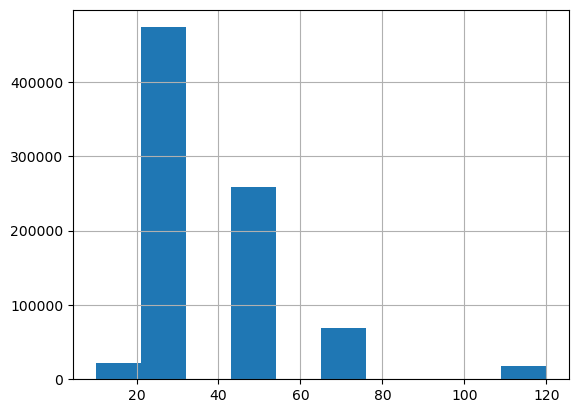

In [70]:
users_segment_filled_df['income'].hist()

Можно объединить пользователей с доходом:
* до 40 ~ 0
* от 40 до 80 ~ 1
* от 100 до 120 ~ 2

In [71]:
users_segment_final['segm_income'] = pd.cut(
    users_segment_final['income'],
    [0, 40, 80, 130],
    labels=[0, 1, 2]
)

In [72]:
pd.concat([
    users_segment_final.head(2), users_segment_final.tail(2)])

,user_id,age,income,sex,kids_flg,segm_age,segm_income
0,973171,29.5,75.0,0,1,0,1
1,962099,21.0,30.0,0,0,0,0
840195,590706,49.5,50.0,1,0,1,1
840196,166555,69.5,30.0,1,0,2,0


Для тестов остановимся на четырех разбиениях:

1) То, которое описано выше
2) Всевозможные по всем признакам
3) Только по полу
4) По полу и детям

В процессе работы было выявлено, что слишком большое количество сегментов порождает маленькие группы из людей, которые сомтрели один и тот же фильм. В данном случае рекомендации на основе knn показывают себя не слишком хорошо и требуют дополнения другими подходами.

Сформируем итоговые разбиения по сегментам:

In [73]:
def split_into_segments(
    df: pd.DataFrame,
    columns: list
) -> pd.DataFrame:
    segments = (df.groupby(columns).agg({'user_id': list})).dropna()
    indx_map = {indx: i for i, indx in enumerate(segments.index)}
    segment_users = pd.DataFrame({
        'user_id': segments['user_id'].reset_index(drop=True),
        'segm': segments.index.map(indx_map.get).tolist()
    }).explode('user_id')
    return segment_users

In [74]:
custom_features = ['sex', 'kids_flg', 'segm_age', 'segm_income']
all_features = ['sex', 'kids_flg', 'age', 'income']
sex_features = ['sex']
kids_features = ['sex', 'kids_flg']

In [75]:
segment_users_custom = split_into_segments(
    users_segment_final, custom_features)

segment_users_all = split_into_segments(
    users_segment_final, all_features)

segment_users_sex = split_into_segments(
    users_segment_final, sex_features)

segment_users_kids = split_into_segments(
    users_segment_final, kids_features)


segment_users = pd.merge(
    segment_users_custom, segment_users_all,
    how='left', on='user_id', suffixes=['_custom', '_all']
)

segment_users = pd.merge(
    segment_users, segment_users_sex,
    how='left', on='user_id'
)

segment_users = pd.merge(
    segment_users, segment_users_kids,
    how='left', on='user_id', suffixes=['_sex', '_kids']
)

In [76]:
print(segment_users.shape)
pd.concat([segment_users.head(3), segment_users.tail(3)])

(840197, 5)


,user_id,segm_custom,segm_all,segm_sex,segm_kids
0,962099,0,1,0,0
1,391756,0,6,0,0
2,382508,0,1,0,0
840194,283867,35,136,1,3
840195,377972,35,142,1,3
840196,1001120,35,136,1,3


In [77]:
for col in ['segm_custom', 'segm_all', 'segm_sex', 'segm_kids']:
    print(f'{col}:', segment_users[col].unique().shape)

segm_custom: (36,)
segm_all: (143,)
segm_sex: (2,)
segm_kids: (4,)


In [78]:
segment_users.to_csv('kion_train/users_segment.csv', index=False)

In [16]:
segment_users = pd.read_csv('kion_train/users_segment.csv')

In [17]:
pd.concat([segment_users.head(3), segment_users.tail(3)])

,user_id,segm_custom,segm_all,segm_sex,segm_kids
0,962099,0,1,0,0
1,391756,0,6,0,0
2,382508,0,1,0,0
840194,283867,35,136,1,3
840195,377972,35,142,1,3
840196,1001120,35,136,1,3


### Реализация модели по сегментам

In [15]:
from typing import List


class SegmentKNN:
    def __init__(
        self,
        base_estimator: UserKnn,
        sub_estimator,
        base_estimator_kwargs: dict = None,
        sub_estimator_kwargs: dict = None,
        sub_estimators_predict_kwargs: dict = None
    ):
        self.base_estimator = base_estimator
        self.sub_estimator = sub_estimator
        self.sub_estimators = {}
        self.is_fitted = False
        self.users_segment_map = None
        
        self.base_estimator_kwargs = base_estimator_kwargs
        self.sub_estimator_kwargs = sub_estimator_kwargs
        self.sub_estimators_predict_kwargs = sub_estimators_predict_kwargs
    
    def _calc_users_segment_map(
        self, train, user_segment_df, segm_col
    ):
        train_users = train['user_id'].unique()
        mask = user_segment_df['user_id'].isin(train_users)
        self.users_segment_map = {
            user_id: segm for user_id, segm in
            zip(user_segment_df[mask]['user_id'],
                user_segment_df[mask][segm_col])
        }
    
    def _remove_from_users_map(self, users_ids: List[int]):
        for user_id in users_ids:
            del self.users_segment_map[user_id]
    
    def fit(
        self,
        train: pd.DataFrame,
        user_segment_df: pd.DataFrame,
        segm_col: str
    ):
        self._calc_users_segment_map(
            train, user_segment_df, segm_col
        )
        # train base estimators over all existing segments:
        for k in user_segment_df[segm_col].unique():
            # make train DataFrame over current segment:
            users_segm = user_segment_df[
                user_segment_df[segm_col]==k
            ]['user_id']
            segm_train = train[train['user_id'].isin(users_segm)]
            # train sub estimator over current segment
            if segm_train.shape[0] > 1:
                # init sub estimator:
                if self.sub_estimator_kwargs is None:
                    sub_model = self.sub_estimator()
                else:
                    sub_model = self.sub_estimator(
                        **self.sub_estimator_kwargs
                    )
                # init base estimator:
                if self.base_estimator_kwargs is None:
                    knn_model = self.base_estimator(model=sub_model)
                else:
                    knn_model = self.base_estimator(
                        model=sub_model,
                        **self.base_estimator_kwargs
                    )
                # train base estimator:
                knn_model.fit(segm_train)
                self.sub_estimators[k] = knn_model
            else:
                self._remove_from_users_map(
                    segm_train['user_id'].tolist()
                )
                
        self.is_fitted = True
                
    def predict(self, test: pd.DataFrame, N_recs: int = 10):
        
        if not self.is_fitted:
            raise ValueError("Please call fit before predict")
        
        # figure out users segments:
        pred_test = test.copy()
        pred_test['segm'] = pred_test['user_id'].map(
            self.users_segment_map.get)
        
        def make_pred(col):
            # prediction for each user in segment
            if self.sub_estimators_predict_kwargs is None:
                pred = self.sub_estimators[
                    self.users_segment_map[col.iloc[0]]
                ].predict(
                    pd.DataFrame({'user_id': col}), N_recs
                )
            else:
                pred = self.sub_estimators[
                    self.users_segment_map[col.iloc[0]]
                ].predict(
                    pd.DataFrame({'user_id': col}), N_recs,
                    **self.sub_estimators_predict_kwargs
                )
            return pred.values.tolist()
        
        # make prediction for each segment
        pred = pred_test.groupby('segm').agg(
            {'user_id': lambda col: make_pred(col)}
        ).explode('user_id')

        # convert arrays into columns:
        cols = ['user_id', 'item_id', 'score', 'rank']
        for i in range(len(cols)-1, -1, -1):
            pred[cols[i]] = pred['user_id'].apply(
                lambda val: val[i])
        
        return pred[cols].reset_index(drop=True)

In [82]:
segment_kNN_all = SegmentKNN(
    base_estimator=UserKnn,
    sub_estimator=CosineRecommender,
)

In [83]:
segment_kNN_all.fit(train, segment_users, 'segm_all')

  0%|          | 0/20698 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/31727 [00:00<?, ?it/s]

  0%|          | 0/1435 [00:00<?, ?it/s]

  0%|          | 0/27473 [00:00<?, ?it/s]

  0%|          | 0/5651 [00:00<?, ?it/s]

  0%|          | 0/6621 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/967 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/19422 [00:00<?, ?it/s]

  0%|          | 0/16993 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/5347 [00:00<?, ?it/s]

  0%|          | 0/17558 [00:00<?, ?it/s]

  0%|          | 0/15256 [00:00<?, ?it/s]

  0%|          | 0/5914 [00:00<?, ?it/s]

  0%|          | 0/1803 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1252 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/12974 [00:00<?, ?it/s]

  0%|          | 0/9293 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/7160 [00:00<?, ?it/s]

  0%|          | 0/4237 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/12009 [00:00<?, ?it/s]

  0%|          | 0/4005 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/3255 [00:00<?, ?it/s]

  0%|          | 0/10644 [00:00<?, ?it/s]

  0%|          | 0/1576 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16728 [00:00<?, ?it/s]

  0%|          | 0/7306 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/19359 [00:00<?, ?it/s]

  0%|          | 0/7543 [00:00<?, ?it/s]

  0%|          | 0/8425 [00:00<?, ?it/s]

  0%|          | 0/3666 [00:00<?, ?it/s]

  0%|          | 0/914 [00:00<?, ?it/s]

  0%|          | 0/1622 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1757 [00:00<?, ?it/s]

  0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1518 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/40168 [00:00<?, ?it/s]

  0%|          | 0/44451 [00:00<?, ?it/s]

  0%|          | 0/4124 [00:00<?, ?it/s]

  0%|          | 0/2263 [00:00<?, ?it/s]

  0%|          | 0/18437 [00:00<?, ?it/s]

  0%|          | 0/4696 [00:00<?, ?it/s]

  0%|          | 0/7798 [00:00<?, ?it/s]

  0%|          | 0/894 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18873 [00:00<?, ?it/s]

  0%|          | 0/23559 [00:00<?, ?it/s]

  0%|          | 0/772 [00:00<?, ?it/s]

  0%|          | 0/1047 [00:00<?, ?it/s]

  0%|          | 0/9331 [00:00<?, ?it/s]

  0%|          | 0/3155 [00:00<?, ?it/s]

  0%|          | 0/11215 [00:00<?, ?it/s]

  0%|          | 0/2417 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/642 [00:00<?, ?it/s]

  0%|          | 0/13999 [00:00<?, ?it/s]

  0%|          | 0/15006 [00:00<?, ?it/s]

  0%|          | 0/653 [00:00<?, ?it/s]

  0%|          | 0/694 [00:00<?, ?it/s]

  0%|          | 0/3835 [00:00<?, ?it/s]

  0%|          | 0/4219 [00:00<?, ?it/s]

  0%|          | 0/567 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8169 [00:00<?, ?it/s]

  0%|          | 0/17728 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/8249 [00:00<?, ?it/s]

  0%|          | 0/1925 [00:00<?, ?it/s]

  0%|          | 0/2261 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20184 [00:00<?, ?it/s]

  0%|          | 0/8568 [00:00<?, ?it/s]

  0%|          | 0/755 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

  0%|          | 0/11975 [00:00<?, ?it/s]

  0%|          | 0/1617 [00:00<?, ?it/s]

  0%|          | 0/3629 [00:00<?, ?it/s]

  0%|          | 0/5030 [00:00<?, ?it/s]

  0%|          | 0/322 [00:00<?, ?it/s]

  0%|          | 0/742 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/2296 [00:00<?, ?it/s]

  0%|          | 0/1559 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [84]:
segment_kNN_all_pred = segment_kNN_all.predict(test.iloc[:10])

In [85]:
segment_kNN_all_pred

,user_id,item_id,score,rank
0,910002,6380,3.671042,1
1,910002,6082,3.595443,2
2,910002,79,3.544775,3
3,910002,11324,3.424944,4
4,910002,3066,2.885003,5
...,...,...,...,...
65,1061176,12356,1.471100,6
66,1061176,1399,1.463880,7
67,1061176,5732,1.461107,8
68,1061176,15464,1.387223,9


### Тестирование моделей по сегментам

#### kNN без дополнения популярным

In [18]:
# all segments
segment_kNN_all = SegmentKNN(
    base_estimator=UserKnn,
    sub_estimator=CosineRecommender,
)

In [19]:
segment_kNN_all.fit(train, segment_users, 'segm_all')

  0%|          | 0/20698 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/31727 [00:00<?, ?it/s]

  0%|          | 0/1435 [00:00<?, ?it/s]

  0%|          | 0/27473 [00:00<?, ?it/s]

  0%|          | 0/5651 [00:00<?, ?it/s]

  0%|          | 0/6621 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/967 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/19422 [00:00<?, ?it/s]

  0%|          | 0/16993 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/5347 [00:00<?, ?it/s]

  0%|          | 0/17558 [00:00<?, ?it/s]

  0%|          | 0/15256 [00:00<?, ?it/s]

  0%|          | 0/5914 [00:00<?, ?it/s]

  0%|          | 0/1803 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1252 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/12974 [00:00<?, ?it/s]

  0%|          | 0/9293 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/7160 [00:00<?, ?it/s]

  0%|          | 0/4237 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/12009 [00:00<?, ?it/s]

  0%|          | 0/4005 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/3255 [00:00<?, ?it/s]

  0%|          | 0/10644 [00:00<?, ?it/s]

  0%|          | 0/1576 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16728 [00:00<?, ?it/s]

  0%|          | 0/7306 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/19359 [00:00<?, ?it/s]

  0%|          | 0/7543 [00:00<?, ?it/s]

  0%|          | 0/8425 [00:00<?, ?it/s]

  0%|          | 0/3666 [00:00<?, ?it/s]

  0%|          | 0/914 [00:00<?, ?it/s]

  0%|          | 0/1622 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1757 [00:00<?, ?it/s]

  0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1518 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/40168 [00:00<?, ?it/s]

  0%|          | 0/44451 [00:00<?, ?it/s]

  0%|          | 0/4124 [00:00<?, ?it/s]

  0%|          | 0/2263 [00:00<?, ?it/s]

  0%|          | 0/18437 [00:00<?, ?it/s]

  0%|          | 0/4696 [00:00<?, ?it/s]

  0%|          | 0/7798 [00:00<?, ?it/s]

  0%|          | 0/894 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18873 [00:00<?, ?it/s]

  0%|          | 0/23559 [00:00<?, ?it/s]

  0%|          | 0/772 [00:00<?, ?it/s]

  0%|          | 0/1047 [00:00<?, ?it/s]

  0%|          | 0/9331 [00:00<?, ?it/s]

  0%|          | 0/3155 [00:00<?, ?it/s]

  0%|          | 0/11215 [00:00<?, ?it/s]

  0%|          | 0/2417 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/642 [00:00<?, ?it/s]

  0%|          | 0/13999 [00:00<?, ?it/s]

  0%|          | 0/15006 [00:00<?, ?it/s]

  0%|          | 0/653 [00:00<?, ?it/s]

  0%|          | 0/694 [00:00<?, ?it/s]

  0%|          | 0/3835 [00:00<?, ?it/s]

  0%|          | 0/4219 [00:00<?, ?it/s]

  0%|          | 0/567 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8169 [00:00<?, ?it/s]

  0%|          | 0/17728 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/8249 [00:00<?, ?it/s]

  0%|          | 0/1925 [00:00<?, ?it/s]

  0%|          | 0/2261 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20184 [00:00<?, ?it/s]

  0%|          | 0/8568 [00:00<?, ?it/s]

  0%|          | 0/755 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

  0%|          | 0/11975 [00:00<?, ?it/s]

  0%|          | 0/1617 [00:00<?, ?it/s]

  0%|          | 0/3629 [00:00<?, ?it/s]

  0%|          | 0/5030 [00:00<?, ?it/s]

  0%|          | 0/322 [00:00<?, ?it/s]

  0%|          | 0/742 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/2296 [00:00<?, ?it/s]

  0%|          | 0/1559 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
segm_all_knn_recs = pd.concat([
    segment_kNN_all.predict(test.iloc[:69174]),
    segment_kNN_all.predict(test.iloc[69174:138349]),
    segment_kNN_all.predict(test.iloc[138349:207524]),
    segment_kNN_all.predict(test.iloc[207524:])
])

In [21]:
metric.calc(segm_all_knn_recs, test)

0.004599287035040938

In [22]:
# custom segments
segment_kNN_custom = SegmentKNN(
    base_estimator=UserKnn,
    sub_estimator=CosineRecommender,
)

In [23]:
segment_kNN_custom.fit(train, segment_users, 'segm_custom')

  0%|          | 0/54595 [00:00<?, ?it/s]

  0%|          | 0/40529 [00:00<?, ?it/s]

  0%|          | 0/1066 [00:00<?, ?it/s]

  0%|          | 0/37044 [00:00<?, ?it/s]

  0%|          | 0/44075 [00:00<?, ?it/s]

  0%|          | 0/3299 [00:00<?, ?it/s]

  0%|          | 0/22680 [00:00<?, ?it/s]

  0%|          | 0/13848 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/16590 [00:00<?, ?it/s]

  0%|          | 0/15681 [00:00<?, ?it/s]

  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/24349 [00:00<?, ?it/s]

  0%|          | 0/38993 [00:00<?, ?it/s]

  0%|          | 0/2687 [00:00<?, ?it/s]

  0%|          | 0/2514 [00:00<?, ?it/s]

  0%|          | 0/2666 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/91006 [00:00<?, ?it/s]

  0%|          | 0/31825 [00:00<?, ?it/s]

  0%|          | 0/1184 [00:00<?, ?it/s]

  0%|          | 0/44251 [00:00<?, ?it/s]

  0%|          | 0/26118 [00:00<?, ?it/s]

  0%|          | 0/1553 [00:00<?, ?it/s]

  0%|          | 0/30300 [00:00<?, ?it/s]

  0%|          | 0/9315 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/27732 [00:00<?, ?it/s]

  0%|          | 0/12631 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/29852 [00:00<?, ?it/s]

  0%|          | 0/22251 [00:00<?, ?it/s]

  0%|          | 0/1157 [00:00<?, ?it/s]

  0%|          | 0/4050 [00:00<?, ?it/s]

  0%|          | 0/1790 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [24]:
segm_custom_knn_recs = pd.concat([
    segment_kNN_custom.predict(test.iloc[:69174]),
    segment_kNN_custom.predict(test.iloc[69174:138349]),
    segment_kNN_custom.predict(test.iloc[138349:207524]),
    segment_kNN_custom.predict(test.iloc[207524:])
])

In [25]:
metric.calc(segm_custom_knn_recs, test)

0.004437599162475825

In [26]:
# sex segments
segment_kNN_sex = SegmentKNN(
    base_estimator=UserKnn,
    sub_estimator=CosineRecommender,
)

In [27]:
segment_kNN_sex.fit(train, segment_users, 'segm_sex')

  0%|          | 0/321777 [00:00<?, ?it/s]

  0%|          | 0/335759 [00:00<?, ?it/s]

In [28]:
segm_sex_knn_recs = pd.concat([
    segment_kNN_sex.predict(test.iloc[:69174]),
    segment_kNN_sex.predict(test.iloc[69174:138349]),
    segment_kNN_sex.predict(test.iloc[138349:207524]),
    segment_kNN_sex.predict(test.iloc[207524:])
])

In [29]:
metric.calc(segm_sex_knn_recs, test)

0.003987131389167915

In [30]:
# kids segments
segment_kNN_kids = SegmentKNN(
    base_estimator=UserKnn,
    sub_estimator=CosineRecommender,
)

In [31]:
segment_kNN_kids.fit(train, segment_users, 'segm_kids')

  0%|          | 0/217556 [00:00<?, ?it/s]

  0%|          | 0/104221 [00:00<?, ?it/s]

  0%|          | 0/235792 [00:00<?, ?it/s]

  0%|          | 0/99967 [00:00<?, ?it/s]

In [32]:
segm_kids_knn_recs = pd.concat([
    segment_kNN_kids.predict(test.iloc[:69174]),
    segment_kNN_kids.predict(test.iloc[69174:138349]),
    segment_kNN_kids.predict(test.iloc[138349:207524]),
    segment_kNN_kids.predict(test.iloc[207524:])
])

In [33]:
metric.calc(segm_kids_knn_recs, test)

0.004043987192002653

#### kNN с дополнением популярным

In [34]:
# all segments
base_estimator_kwargs = {'pop_items': items_pop_ordered}
sub_estimators_predict_kwargs = {'complete_method': 'popular'}

segment_pop_kNN_all = SegmentKNN(
    base_estimator=UserKnnComplete,
    sub_estimator=CosineRecommender,
    base_estimator_kwargs=base_estimator_kwargs,
    sub_estimators_predict_kwargs=sub_estimators_predict_kwargs
)

In [35]:
segment_pop_kNN_all.fit(train, segment_users, 'segm_all')

  0%|          | 0/20698 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/31727 [00:00<?, ?it/s]

  0%|          | 0/1435 [00:00<?, ?it/s]

  0%|          | 0/27473 [00:00<?, ?it/s]

  0%|          | 0/5651 [00:00<?, ?it/s]

  0%|          | 0/6621 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/967 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/19422 [00:00<?, ?it/s]

  0%|          | 0/16993 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/5347 [00:00<?, ?it/s]

  0%|          | 0/17558 [00:00<?, ?it/s]

  0%|          | 0/15256 [00:00<?, ?it/s]

  0%|          | 0/5914 [00:00<?, ?it/s]

  0%|          | 0/1803 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1252 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/12974 [00:00<?, ?it/s]

  0%|          | 0/9293 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/7160 [00:00<?, ?it/s]

  0%|          | 0/4237 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/12009 [00:00<?, ?it/s]

  0%|          | 0/4005 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/3255 [00:00<?, ?it/s]

  0%|          | 0/10644 [00:00<?, ?it/s]

  0%|          | 0/1576 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16728 [00:00<?, ?it/s]

  0%|          | 0/7306 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/19359 [00:00<?, ?it/s]

  0%|          | 0/7543 [00:00<?, ?it/s]

  0%|          | 0/8425 [00:00<?, ?it/s]

  0%|          | 0/3666 [00:00<?, ?it/s]

  0%|          | 0/914 [00:00<?, ?it/s]

  0%|          | 0/1622 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1757 [00:00<?, ?it/s]

  0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1518 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/40168 [00:00<?, ?it/s]

  0%|          | 0/44451 [00:00<?, ?it/s]

  0%|          | 0/4124 [00:00<?, ?it/s]

  0%|          | 0/2263 [00:00<?, ?it/s]

  0%|          | 0/18437 [00:00<?, ?it/s]

  0%|          | 0/4696 [00:00<?, ?it/s]

  0%|          | 0/7798 [00:00<?, ?it/s]

  0%|          | 0/894 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18873 [00:00<?, ?it/s]

  0%|          | 0/23559 [00:00<?, ?it/s]

  0%|          | 0/772 [00:00<?, ?it/s]

  0%|          | 0/1047 [00:00<?, ?it/s]

  0%|          | 0/9331 [00:00<?, ?it/s]

  0%|          | 0/3155 [00:00<?, ?it/s]

  0%|          | 0/11215 [00:00<?, ?it/s]

  0%|          | 0/2417 [00:00<?, ?it/s]

  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/642 [00:00<?, ?it/s]

  0%|          | 0/13999 [00:00<?, ?it/s]

  0%|          | 0/15006 [00:00<?, ?it/s]

  0%|          | 0/653 [00:00<?, ?it/s]

  0%|          | 0/694 [00:00<?, ?it/s]

  0%|          | 0/3835 [00:00<?, ?it/s]

  0%|          | 0/4219 [00:00<?, ?it/s]

  0%|          | 0/567 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8169 [00:00<?, ?it/s]

  0%|          | 0/17728 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/8249 [00:00<?, ?it/s]

  0%|          | 0/1925 [00:00<?, ?it/s]

  0%|          | 0/2261 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20184 [00:00<?, ?it/s]

  0%|          | 0/8568 [00:00<?, ?it/s]

  0%|          | 0/755 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

  0%|          | 0/11975 [00:00<?, ?it/s]

  0%|          | 0/1617 [00:00<?, ?it/s]

  0%|          | 0/3629 [00:00<?, ?it/s]

  0%|          | 0/5030 [00:00<?, ?it/s]

  0%|          | 0/322 [00:00<?, ?it/s]

  0%|          | 0/742 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/2296 [00:00<?, ?it/s]

  0%|          | 0/1559 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [36]:
segm_all_pop_knn_recs = pd.concat([
    segment_pop_kNN_all.predict(test.iloc[:69174]),
    segment_pop_kNN_all.predict(test.iloc[69174:138349]),
    segment_pop_kNN_all.predict(test.iloc[138349:207524]),
    segment_pop_kNN_all.predict(test.iloc[207524:])
])

In [37]:
metric.calc(segm_all_pop_knn_recs, test)

0.02276592843309204

In [38]:
# custom segments
base_estimator_kwargs = {'pop_items': items_pop_ordered}
sub_estimators_predict_kwargs = {'complete_method': 'popular'}

segment_pop_kNN_custom = SegmentKNN(
    base_estimator=UserKnnComplete,
    sub_estimator=CosineRecommender,
    base_estimator_kwargs=base_estimator_kwargs,
    sub_estimators_predict_kwargs=sub_estimators_predict_kwargs
)

In [39]:
segment_pop_kNN_custom.fit(train, segment_users, 'segm_custom')

  0%|          | 0/54595 [00:00<?, ?it/s]

  0%|          | 0/40529 [00:00<?, ?it/s]

  0%|          | 0/1066 [00:00<?, ?it/s]

  0%|          | 0/37044 [00:00<?, ?it/s]

  0%|          | 0/44075 [00:00<?, ?it/s]

  0%|          | 0/3299 [00:00<?, ?it/s]

  0%|          | 0/22680 [00:00<?, ?it/s]

  0%|          | 0/13848 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/16590 [00:00<?, ?it/s]

  0%|          | 0/15681 [00:00<?, ?it/s]

  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/24349 [00:00<?, ?it/s]

  0%|          | 0/38993 [00:00<?, ?it/s]

  0%|          | 0/2687 [00:00<?, ?it/s]

  0%|          | 0/2514 [00:00<?, ?it/s]

  0%|          | 0/2666 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/91006 [00:00<?, ?it/s]

  0%|          | 0/31825 [00:00<?, ?it/s]

  0%|          | 0/1184 [00:00<?, ?it/s]

  0%|          | 0/44251 [00:00<?, ?it/s]

  0%|          | 0/26118 [00:00<?, ?it/s]

  0%|          | 0/1553 [00:00<?, ?it/s]

  0%|          | 0/30300 [00:00<?, ?it/s]

  0%|          | 0/9315 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/27732 [00:00<?, ?it/s]

  0%|          | 0/12631 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/29852 [00:00<?, ?it/s]

  0%|          | 0/22251 [00:00<?, ?it/s]

  0%|          | 0/1157 [00:00<?, ?it/s]

  0%|          | 0/4050 [00:00<?, ?it/s]

  0%|          | 0/1790 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [40]:
segm_custom_pop_knn_recs = pd.concat([
    segment_pop_kNN_custom.predict(test.iloc[:69174]),
    segment_pop_kNN_custom.predict(test.iloc[69174:138349]),
    segment_pop_kNN_custom.predict(test.iloc[138349:207524]),
    segment_pop_kNN_custom.predict(test.iloc[207524:])
])

In [41]:
metric.calc(segm_custom_pop_knn_recs, test)

0.024237888991157627

In [42]:
# sex segments
base_estimator_kwargs = {'pop_items': items_pop_ordered}
sub_estimators_predict_kwargs = {'complete_method': 'popular'}

segment_pop_kNN_sex = SegmentKNN(
    base_estimator=UserKnnComplete,
    sub_estimator=CosineRecommender,
    base_estimator_kwargs=base_estimator_kwargs,
    sub_estimators_predict_kwargs=sub_estimators_predict_kwargs
)

In [43]:
segment_pop_kNN_sex.fit(train, segment_users, 'segm_sex')

  0%|          | 0/321777 [00:00<?, ?it/s]

  0%|          | 0/335759 [00:00<?, ?it/s]

In [44]:
segm_sex_pop_knn_recs = pd.concat([
    segment_pop_kNN_sex.predict(test.iloc[:69174]),
    segment_pop_kNN_sex.predict(test.iloc[69174:138349]),
    segment_pop_kNN_sex.predict(test.iloc[138349:207524]),
    segment_pop_kNN_sex.predict(test.iloc[207524:])
])

In [45]:
metric.calc(segm_sex_pop_knn_recs, test)

0.02756079577179194

In [46]:
# kids segments
base_estimator_kwargs = {'pop_items': items_pop_ordered}
sub_estimators_predict_kwargs = {'complete_method': 'popular'}

segment_pop_kNN_kids = SegmentKNN(
    base_estimator=UserKnnComplete,
    sub_estimator=CosineRecommender,
    base_estimator_kwargs=base_estimator_kwargs,
    sub_estimators_predict_kwargs=sub_estimators_predict_kwargs
)

In [47]:
segment_pop_kNN_kids.fit(train, segment_users, 'segm_kids')

  0%|          | 0/217556 [00:00<?, ?it/s]

  0%|          | 0/104221 [00:00<?, ?it/s]

  0%|          | 0/235792 [00:00<?, ?it/s]

  0%|          | 0/99967 [00:00<?, ?it/s]

In [48]:
segm_kids_pop_knn_recs = pd.concat([
    segment_pop_kNN_kids.predict(test.iloc[:69174]),
    segment_pop_kNN_kids.predict(test.iloc[69174:138349]),
    segment_pop_kNN_kids.predict(test.iloc[138349:207524]),
    segment_pop_kNN_kids.predict(test.iloc[207524:])
])

In [49]:
metric.calc(segm_kids_pop_knn_recs, test)

0.026829306147079592

## 3.3. Сегментирование пользователей, которых нет в `users`

Имеют место следующие наблюдения относительно данных:

1) В `users` есть пользователи, которых нет в `train` - это пользователи, которые не взаимодействовали с айтемами, но про которых мы что-то знаем. **С ними все окей.** В текущей реализации мы не используем знания об их сегменте как во время обучения (так как обучение построено на взаимодействиях, которых для данных пользователей просто нет), так и во время предсказания, хоть и знаем сегмент пользователей, к которому они пренадлежат. Однако как раз на этапе предсказания для этих пользователей можно возвращать популярное по их сегменту, а не популярное в принципе.


2) В `train` есть пользователи, которых нет в `users` - это пользователи, по которым нет предварительной информации (пол, возраст и т.д.) кроме фактов взаиомдейтсвия с айтемами. Этих пользователей не отнести к категориям, построенным на основе `users`. **Сейчас в модели по сегментам для таких пользователей предсказания не строятся вообще.**


3) Есть пользователи, которые присутсвуют и в `users` и в `train`. **С ними все хорошо**, они сегментируются по тому, что было построено на основе `users`.

Необходимо учесть второй случай и попробовать сегментировать этих пользователей по, например, новым признакам, которые можно построить на основе интеракций. Либо определить данных пользователей в один отдельный сегмент.

Если рассматривать feature engineering, то нужно генерировать признаки грамотно, как можно меньше опираясь на информацию о самих фильмах, либо используя информацию, которая хорошо обобщает пользователей. Потому что в противном случае, если мы соберем пользователей в группы по одинаковым фильмам, то строить рекомендации новых айтемов относительно пользователя на основе его кластера будет просто невозможно.

### Feature engineering

In [34]:
train_out_of_users = train[~train['user_id'].isin(users['user_id'])]

In [35]:
train_out_of_users.shape

(866337, 5)

In [36]:
pd.concat([train_out_of_users.head(3), train_out_of_users.tail(3)])

,user_id,item_id,datetime,weight,watched_pct
5,1032142,6686,2021-05-13,11286.0,100.0
13,602509,496,2021-08-06,10421.0,1.0
16,646903,16228,2021-07-23,57375.0,46.0
5476235,977542,13126,2021-07-04,1830.0,26.0
5476241,1073802,9927,2021-08-07,6425.0,97.0
5476242,268216,3071,2021-04-21,5752.0,98.0


In [37]:
pd.concat([items.head(1), items.tail(1)])

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
15962,3206,series,Гоша,NaN,2019.0,комедии,Россия,0.0,16.0,NaN,Михаил Миронов,"Мкртыч Арзуманян, Виктория Рунцова","Добродушный Гоша не может выйти из дома, чтобы...","Гоша, 2019, Россия"


Возможные признаки:
* Среднее время просмотра за один сеанс
* Среднее количество просмотров в месяц/неделю/...
* Средний возростной рейтинг фильмов

Проверим полноту признаков:

In [38]:
train_out_of_users['weight'].isna().any()

False

In [39]:
train_out_of_users['datetime'].isna().any()

False

In [40]:
print(items['age_rating'].isna().any())
items[items['age_rating'].isna()].shape[0]

True


2

In [41]:
without_age_rating = items[items['age_rating'].isna()]
without_age_rating

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
8297,6316,series,Машины-помощники,NaN,2016.0,"русские, для детей, сериалы, хочу всё знать, р...",Россия,NaN,NaN,NaN,NaN,NaN,Маленькие мальчики всего мира любят играть в м...,"Машины-помощники, 2017, Россия, работа, преодо..."
12352,14409,series,БиБаБу,NaN,2017.0,"русские, сериалы, для детей, хочу всё знать, р...",Россия,NaN,NaN,NaN,NaN,NaN,В сказочное подводное царство приглашают мален...,"друзья, магия и волшебство, рыбы, моря и океан..."


Посмотрим, есть ли данные айтемы в `train`  выборке. Если нет, то хорошо, если есть, то два айтема вполне можно заполнить и руками.

In [42]:
train['item_id'].isin(
    items[items['age_rating'].isna()]['item_id']
).any()

True

In [43]:
train[
    train['item_id'].isin(
    items[items['age_rating'].isna()]['item_id']
)].shape[0]

5

Дозаполним пропуски.

Это мультфильмы для малышей, положим возрастной рейтинг равным $0$:

In [44]:
items.loc[without_age_rating.index, 'age_rating'] = [0, 0]

In [45]:
items.loc[without_age_rating.index]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
8297,6316,series,Машины-помощники,NaN,2016.0,"русские, для детей, сериалы, хочу всё знать, р...",Россия,NaN,0.0,NaN,NaN,NaN,Маленькие мальчики всего мира любят играть в м...,"Машины-помощники, 2017, Россия, работа, преодо..."
12352,14409,series,БиБаБу,NaN,2017.0,"русские, сериалы, для детей, хочу всё знать, р...",Россия,NaN,0.0,NaN,NaN,NaN,В сказочное подводное царство приглашают мален...,"друзья, магия и волшебство, рыбы, моря и океан..."


In [46]:
items['age_rating'].isna().any()

False

Сформируем признаки для пользователей:
* Среднее время просмотра за один сеанс
* Средний возростной рейтинг фильмов

In [47]:
from sklearn.preprocessing import MinMaxScaler

In [48]:
train_out_of_users.head(2)

,user_id,item_id,datetime,weight,watched_pct
5,1032142,6686,2021-05-13,11286.0,100.0
13,602509,496,2021-08-06,10421.0,1.0


In [49]:
train_out_features = train_out_of_users.merge(
    items[['item_id', 'age_rating']], on='item_id', how='left'
).groupby('user_id').agg(
    **{'mean_weight': ('weight', 'mean'),
       'mean_age_rating': ('age_rating', 'mean')}
).round(2)

In [50]:
minmax_scaler = MinMaxScaler()

train_out_features['mean_weight_scaled'] =\
    minmax_scaler.fit_transform(train_out_features[['mean_weight']])

In [51]:
train_out_features.reset_index().head()

,user_id,mean_weight,mean_age_rating,mean_weight_scaled
0,3,7227.89,16.11,0.003825
1,5,442.06,21.00,0.000233
2,14,450863.00,18.00,0.238652
3,15,4211.75,15.25,0.002229
4,27,30725.00,18.00,0.016263


In [17]:
import matplotlib.pyplot as plt

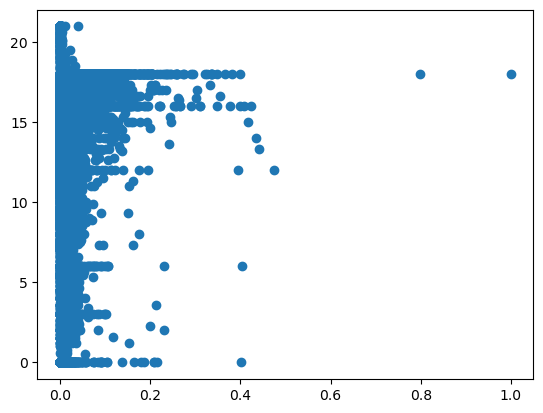

In [53]:
fig, ax = plt.subplots()
ax.scatter(
    train_out_features['mean_weight_scaled'],
    train_out_features['mean_age_rating'])
plt.show()

Время просмотра содержит выбросы или просто очень большие значения и требует нормализации для использования его в качестве информативного фактора. Визуальная информативность признаков в целом отсутствует. Кажется, рейтинги фильмов смотрят примерно равномерно, но  небольшим перевесом между $13$ и $18$. Посмотрим на гистограмму данного признака:

<AxesSubplot:>

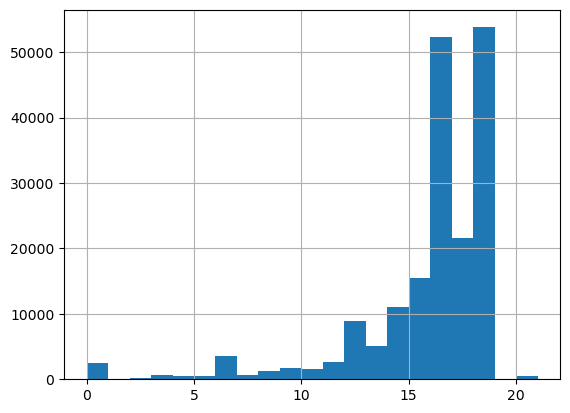

In [54]:
train_out_features['mean_age_rating'].hist(bins=21)

В целом признак среднего возрастного рейтинга можно использовать для сегментации юзеров, например:
* от 0 до 7
* от 7 до 13
* от 13 до 14
* от 14 до 16
* от 16 до 21

Из признаков, коррелирующих со временем просмотра, можно извлечь информацию о пользователях, которые смотрят очень много. Скорее всего таким пользователям разумно рекомендовать популярное или новое. Вопрос состоит в том, получится ли четко выделить таких пользователей.

<AxesSubplot:>

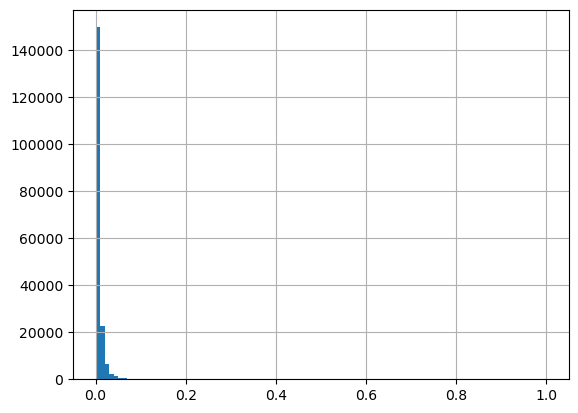

In [55]:
train_out_features['mean_weight_scaled'].hist(bins=100)

Можно изучить признак, который будет строиться из среднего числа взаимодействий, некоторым образом отшкалированный на время просмотра за тот же период и посомтреть, что получится. Однако пока что остановимся на том, что есть и перейдем к еще одному признаку.

Рассмотрим признак, на основе типа контента - сериал/фильм.

In [56]:
items['content_type'].isna().any()

False

In [57]:
items['content_type'].unique()

array(['film', 'series'], dtype=object)

Попробуем оценить, что больше предпочитает тот или иной пользователь - сериалы, фильмы или и то и другое. Для этого посчитаем отношение сериалов к фильмам с учетом весов.

In [58]:
content_type_map = {'film': 0, 'series': 1}

def figure_content_type(content_type_col):
    return np.average(
        content_type_col,
        weights=train_content_type.loc[
            content_type_col.index, 'weight']
    )


train_content_type = train_out_of_users.merge(
    items[['item_id', 'content_type']], on='item_id', how='left'
)
train_content_type['content_type'] = train_content_type[
    'content_type'
].map(content_type_map.get)

In [59]:
train_content_type_rate = train_content_type.groupby('user_id').agg(
    **{'content_type_rate': ('content_type', figure_content_type)}
)

In [63]:
train_content_type_rate.reset_index().to_csv(
    'kion_train/train_out_users_content_type_rate.csv',
    index=False
)

In [64]:
train_content_type_rate = pd.read_csv(
    'kion_train/train_out_users_content_type_rate.csv')

In [65]:
train_content_type_rate.head(3)

,user_id,content_type_rate
0,3,0.533969
1,5,0.000000
2,14,1.000000


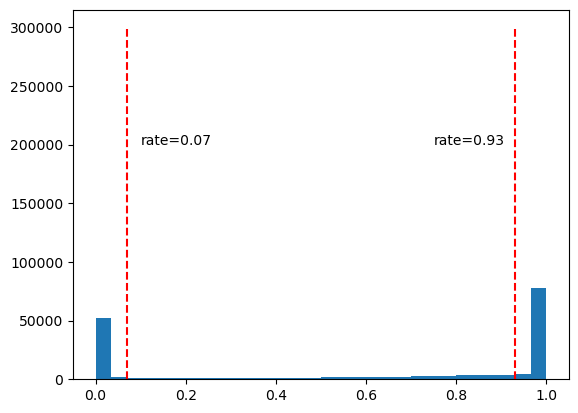

In [66]:
fig, ax = plt.subplots()
ax.hist(train_content_type_rate['content_type_rate'], bins=30)
ax.plot([0.07, 0.07], [0, 300000], 'r--')
ax.text(0.1, 200000, 'rate=0.07')
ax.plot([0.93, 0.93], [0, 300000], 'r--')
ax.text(0.75, 200000, 'rate=0.93')
plt.show()

Можно предположить, что пользователи с рейтингом типа фильма меньше $0.07$ больше предпочитают фильмы, а выше $0.93$ - сериалы. Однако данный результат был получен в том числе с тех пользователей, кто посмотрели небольшое количество картин и делать выводы на такой выборке не стоит. Посмотрим на распределение количества числа взаимодействий:

<AxesSubplot:>

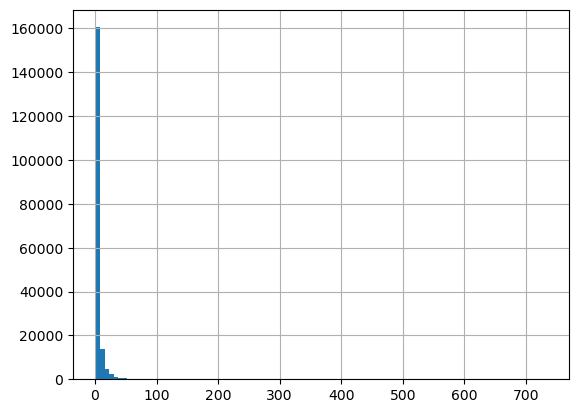

In [67]:
train_out_of_users.groupby('user_id').count()['item_id'].hist(
    bins=100
)

Видно, что лишь небольшое количество пользователей от всей массы имеют репрезентативное количество взаимодействий.

<AxesSubplot:>

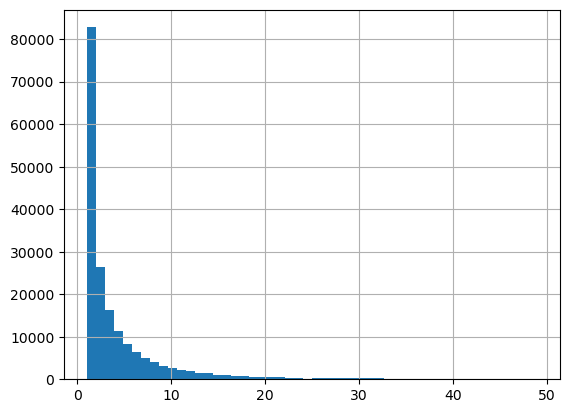

In [68]:
count_inters = train_out_of_users.groupby('user_id').count()
count_inters[count_inters['item_id'] < 50]['item_id'].hist(
    bins=50
)

Рассмотрим пользователей, которые имеют более $15$ взаимодействий:

In [69]:
users_inters_more_15 = count_inters.reset_index()[
    count_inters.reset_index()['item_id'] > 15
]['user_id']

In [70]:
train_u15_content_type = train_out_of_users[
    train_out_of_users['user_id'].isin(users_inters_more_15)
].merge(
    items[['item_id', 'content_type']], on='item_id', how='left'
)
train_u15_content_type['content_type'] = train_u15_content_type[
    'content_type'
].map(content_type_map.get)

train_u15_content_type_rate = (
    train_u15_content_type
    .groupby('user_id')
    .agg(
        **{'content_type_rate': ('content_type',
                                 figure_content_type)}
    )
)

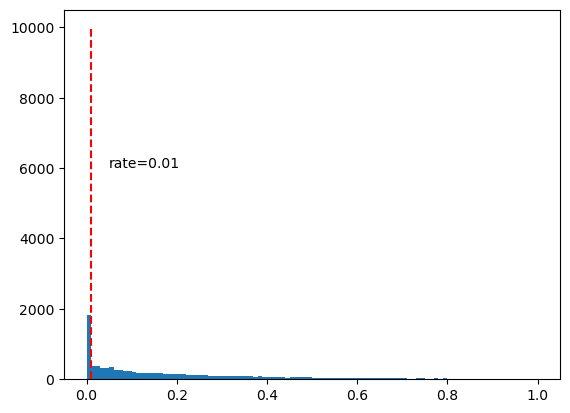

In [71]:
fig, ax = plt.subplots()
ax.hist(train_u15_content_type_rate['content_type_rate'], bins=100)
ax.plot([0.01, 0.01], [0, 10000], 'r--')
ax.text(0.05, 6000, 'rate=0.01')
plt.show()

Теперь можно предполагать, что пользователи, посмотревшие более $15$ картин, больше предпочитают фильмы, если соответсвующий рейтинг типа картины меньше $0.01$. Однако в виду того, что распределение рейтингов несимметричное, не понятно, в какой момент пользователи отдают предпочтение сериалам.

Скорее всего здесь можно уменьшить количество классов до двух:
* $\leq0.01$ фильмы
* $>0.01$ фильмы или сериалы

По итогу будем использовать следующие сегменты для разделения пользователей, о которых у нас нет никаких данных кроме взаимодейтвий:

1) По среднему возрастному рейтингу просмотренных картин:
  * от 0 до 7
  * от 7 до 13
  * от 13 до 14
  * от 14 до 16
  * от 16 до 21
  
  
2) По предпочтениям типа контента для пользователей с количеством просмотров > 15:
  * $\leq0.01$ фильмы
  * $>0.01$ фильмы или сериалы


3) Без разбиения в принципе

In [72]:
train_out_features_final = (
    train_out_features.reset_index()[['user_id', 'mean_age_rating']]
    .merge(train_u15_content_type_rate, on='user_id', how='left')
)

In [74]:
age_rate_bins = [-0.1, 7, 13, 14, 16, 23]
train_out_features_final['segm_age_rate'] = pd.cut(
    train_out_features_final['mean_age_rating'],
    bins=age_rate_bins, labels=range(len(age_rate_bins)-1)
).astype(int)

In [75]:
content_rate_bins = [-0.1, 0.01, 1.1]
train_out_features_final['segm_content_rate'] = pd.cut(
    train_out_features_final['content_type_rate'],
    bins=content_rate_bins, labels=range(len(content_rate_bins)-1)
).astype(float)

segm_conten_na_indx = train_out_features_final[
    train_out_features_final['segm_content_rate'].isna()
].index

train_out_features_final.loc[
    segm_conten_na_indx, 'segm_content_rate'
] = train_out_features_final['segm_content_rate'].max() + 1

train_out_features_final.loc[
    train_out_features_final.index, 'segm_content_rate'
] = train_out_features_final['segm_content_rate'].astype(int)

In [79]:
age_and_content = ['segm_age_rate', 'segm_content_rate']
segment_age_and_content = split_into_segments(
    train_out_features_final, age_and_content).rename(
    columns={'segm': 'segm_age_and_content_rate'}
)

train_out_features_final = pd.merge(
    train_out_features_final,
    segment_age_and_content,
    on='user_id', how='left'
)

In [80]:
train_out_features_final['segm_without'] = 0

In [81]:
train_out_features_final.drop(
    columns=['mean_age_rating', 'content_type_rate'], inplace=True
)

In [82]:
train_out_features_final.to_csv(
    'segm_train_out_users.csv',
    index=False
)

In [17]:
segm_train_out_users = pd.read_csv('segm_train_out_users.csv')

In [18]:
pd.concat([
    segm_train_out_users.head(3),
    segm_train_out_users.tail(3)
])

,user_id,segm_age_rate,segm_content_rate,segm_without,segm_age_and_content_rate
0,3,4,1,0,13
1,5,4,0,0,12
2,14,4,2,0,14
184590,1097515,3,2,0,11
184591,1097534,3,2,0,11
184592,1097552,4,2,0,14


Протестируем модель на данной части пользователей

### kNN с дополнением популярным_

In [85]:
# out train segm age rate
base_estimator_kwargs = {'pop_items': items_pop_ordered}
sub_estimators_predict_kwargs = {'complete_method': 'popular'}

segment_out_train_pop_kNN_age = SegmentKNN(
    base_estimator=UserKnnComplete,
    sub_estimator=CosineRecommender,
    base_estimator_kwargs=base_estimator_kwargs,
    sub_estimators_predict_kwargs=sub_estimators_predict_kwargs
)

In [86]:
segment_out_train_pop_kNN_age.fit(
    train, segm_train_out_users, 'segm_age_rate')

  0%|          | 0/90491 [00:00<?, ?it/s]

  0%|          | 0/60511 [00:00<?, ?it/s]

  0%|          | 0/8243 [00:00<?, ?it/s]

  0%|          | 0/17271 [00:00<?, ?it/s]

  0%|          | 0/8077 [00:00<?, ?it/s]

In [87]:
segm_out_train_age_pop_knn_recs = pd.concat([
    segment_out_train_pop_kNN_age.predict(test.iloc[:69174]),
    segment_out_train_pop_kNN_age.predict(test.iloc[69174:138349]),
    segment_out_train_pop_kNN_age.predict(test.iloc[138349:207524]),
    segment_out_train_pop_kNN_age.predict(test.iloc[207524:])
])

In [88]:
metric.calc(segm_out_train_age_pop_knn_recs, test)

0.008437109919718902

In [93]:
# out train segm content rate
base_estimator_kwargs = {'pop_items': items_pop_ordered}
sub_estimators_predict_kwargs = {'complete_method': 'popular'}

segment_out_train_pop_kNN_content = SegmentKNN(
    base_estimator=UserKnnComplete,
    sub_estimator=CosineRecommender,
    base_estimator_kwargs=base_estimator_kwargs,
    sub_estimators_predict_kwargs=sub_estimators_predict_kwargs
)

In [94]:
segment_out_train_pop_kNN_content.fit(
    train, segm_train_out_users, 'segm_content_rate')

  0%|          | 0/8454 [00:00<?, ?it/s]

  0%|          | 0/1823 [00:00<?, ?it/s]

  0%|          | 0/174316 [00:00<?, ?it/s]

In [95]:
segm_out_train_content_pop_knn_recs = pd.concat([
    segment_out_train_pop_kNN_content.predict(test.iloc[:69174]),
    segment_out_train_pop_kNN_content.predict(test.iloc[69174:138349]),
    segment_out_train_pop_kNN_content.predict(test.iloc[138349:207524]),
    segment_out_train_pop_kNN_content.predict(test.iloc[207524:])
])

In [96]:
metric.calc(segm_out_train_content_pop_knn_recs, test)

0.00920165505326036

In [97]:
# out train segm age and content rate
base_estimator_kwargs = {'pop_items': items_pop_ordered}
sub_estimators_predict_kwargs = {'complete_method': 'popular'}

segment_out_train_pop_kNN_age_and_content = SegmentKNN(
    base_estimator=UserKnnComplete,
    sub_estimator=CosineRecommender,
    base_estimator_kwargs=base_estimator_kwargs,
    sub_estimators_predict_kwargs=sub_estimators_predict_kwargs
)

In [98]:
segment_out_train_pop_kNN_age_and_content.fit(
    train, segm_train_out_users, 'segm_age_and_content_rate')

  0%|          | 0/1581 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/88599 [00:00<?, ?it/s]

  0%|          | 0/55853 [00:00<?, ?it/s]

  0%|          | 0/7124 [00:00<?, ?it/s]

  0%|          | 0/15220 [00:00<?, ?it/s]

  0%|          | 0/457 [00:00<?, ?it/s]

  0%|          | 0/3944 [00:00<?, ?it/s]

  0%|          | 0/7520 [00:00<?, ?it/s]

  0%|          | 0/902 [00:00<?, ?it/s]

  0%|          | 0/1594 [00:00<?, ?it/s]

  0%|          | 0/714 [00:00<?, ?it/s]

  0%|          | 0/433 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

In [99]:
segm_out_train_age_and_content_pop_knn_recs = pd.concat([
    segment_out_train_pop_kNN_age_and_content.predict(test.iloc[:69174]),
    segment_out_train_pop_kNN_age_and_content.predict(test.iloc[69174:138349]),
    segment_out_train_pop_kNN_age_and_content.predict(test.iloc[138349:207524]),
    segment_out_train_pop_kNN_age_and_content.predict(test.iloc[207524:])
])

In [100]:
metric.calc(segm_out_train_age_and_content_pop_knn_recs, test)

0.008405746078120368

In [101]:
# out train without segm
base_estimator_kwargs = {'pop_items': items_pop_ordered}
sub_estimators_predict_kwargs = {'complete_method': 'popular'}

segment_out_train_pop_kNN_without_segm = SegmentKNN(
    base_estimator=UserKnnComplete,
    sub_estimator=CosineRecommender,
    base_estimator_kwargs=base_estimator_kwargs,
    sub_estimators_predict_kwargs=sub_estimators_predict_kwargs
)

In [102]:
segment_out_train_pop_kNN_without_segm.fit(
    train, segm_train_out_users, 'segm_without')

  0%|          | 0/184593 [00:00<?, ?it/s]

In [103]:
segm_out_train_without_segm_pop_knn_recs = pd.concat([
    segment_out_train_pop_kNN_without_segm.predict(test.iloc[:69174]),
    segment_out_train_pop_kNN_without_segm.predict(test.iloc[69174:138349]),
    segment_out_train_pop_kNN_without_segm.predict(test.iloc[138349:207524]),
    segment_out_train_pop_kNN_without_segm.predict(test.iloc[207524:])
])

In [104]:
metric.calc(segm_out_train_without_segm_pop_knn_recs, test)

0.009249118322461626

## 3.4. Популярное

Большое количество пользователей в истории взаимодействий имеет небольшое количество просмотренных картин:

<AxesSubplot:>

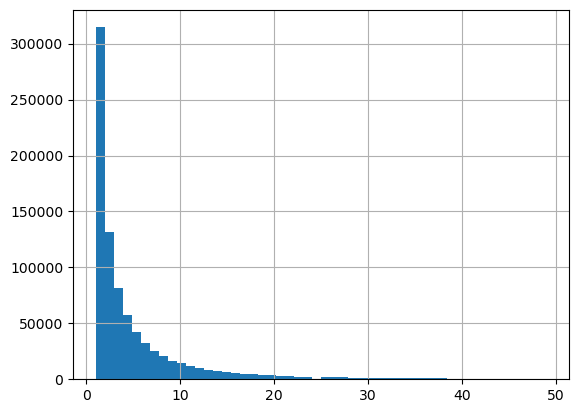

In [105]:
train_count_users_interactions = train.groupby('user_id').count()

train_count_users_interactions[
    train_count_users_interactions['item_id'] < 50
]['item_id'].hist(bins=50)

Необходиомо подобрать порог просмотров, ниже котророго пользователям будет предлагаться популярное.

In [19]:
class PopularWrapper:
    def __init__(
        self,
        base_estimator,
        rec_pops,
        threshold: int,
        base_estimator_fit_kwargs: dict = None
    ):
        self.base_estimator = base_estimator
        self.base_estimator_fit_kwargs = base_estimator_fit_kwargs
        self.rec_pops = rec_pops
        self.threshold = threshold
        
    def fit(self, train: pd.DataFrame):
        train_count_users_interactions = (
            train.groupby('user_id').count()
        )
        self.user_rec_pop_to = train_count_users_interactions[
            train_count_users_interactions[
                'item_id'
            ] < self.threshold
        ].index
        
        if self.base_estimator_fit_kwargs is not None:
            self.base_estimator.fit(
                train[~train['user_id'].isin(self.user_rec_pop_to)],
                **self.base_estimator_fit_kwargs
            )
        else:
            self.base_estimator.fit(
                train[~train['user_id'].isin(self.user_rec_pop_to)]
            )
    
    def predict(
        self,
        test: pd.DataFrame,
        base_estimator_predict_kwargs: dict = None,
        N_recs: int = 10
    ):
        to_base_estimator = test[
            ~test['user_id'].isin(self.user_rec_pop_to)
        ]
        to_pop_rec = test[
            test['user_id'].isin(self.user_rec_pop_to)
        ]
        
        if base_estimator_predict_kwargs is not None:
            pred = pd.concat([
                self.base_estimator.predict(
                    to_base_estimator,
                    **base_estimator_predict_kwargs
                ),
                self._pred_popular(to_pop_rec, N_recs)
            ])
        else:
            pred = pd.concat([
                self.base_estimator.predict(to_base_estimator),
                self._pred_popular(to_pop_rec, N_recs)
            ])
        return pred
        
    def _pred_popular(self, test: pd.DataFrame, N_recs: int,):
        pred = pd.DataFrame({'user_id': test['user_id'].unique()})
        '''
        pred['item_id'] = pred['user_id'].apply(
            lambda val: self.rec_pops.iloc[:10].tolist()
        )
        '''
        
        pred['item_id'] = pred['user_id'].apply(
            lambda val: list(
                zip(self.rec_pops.iloc[:N_recs],
                    np.arange(1, N_recs+1))
            )
        )
        pred = pred.explode('item_id')
        pred['rank'] = pred['item_id'].apply(lambda val: val[1])
        pred['item_id'] = pred['item_id'].apply(lambda val: val[0])
        pred['score'] = 0
        return pred[['user_id', 'item_id', 'score', 'rank']]

In [107]:
base_estimator_kwargs = {'pop_items': items_pop_ordered}
sub_estimators_predict_kwargs = {'complete_method': 'popular'}

segment_out_train_pop_kNN_age_and_content_pop_wrapper = SegmentKNN(
    base_estimator=UserKnnComplete,
    sub_estimator=CosineRecommender,
    base_estimator_kwargs=base_estimator_kwargs,
    sub_estimators_predict_kwargs=sub_estimators_predict_kwargs
)

base_estimator_fit_kwargs = {
    'user_segment_df': segm_train_out_users,
    'segm_col': 'segm_age_and_content_rate'
}

In [108]:
 popular_wrapper = PopularWrapper(
    base_estimator=segment_out_train_pop_kNN_age_and_content_pop_wrapper,
    rec_pops=items_pop_ordered,
    threshold=10,
    base_estimator_fit_kwargs=base_estimator_fit_kwargs
)

In [112]:
popular_wrapper.fit(train)

  0%|          | 0/1581 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/3142 [00:00<?, ?it/s]

  0%|          | 0/4674 [00:00<?, ?it/s]

  0%|          | 0/1009 [00:00<?, ?it/s]

  0%|          | 0/1488 [00:00<?, ?it/s]

  0%|          | 0/457 [00:00<?, ?it/s]

  0%|          | 0/3944 [00:00<?, ?it/s]

  0%|          | 0/383 [00:00<?, ?it/s]

  0%|          | 0/902 [00:00<?, ?it/s]

  0%|          | 0/1594 [00:00<?, ?it/s]

  0%|          | 0/714 [00:00<?, ?it/s]

  0%|          | 0/433 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

In [113]:
base_estimator_predict_kwargs = {
    'N_recs': 10
}

pop_wrapper_segm_out_train_age_and_content_pop_knn_recs = pd.concat([
    popular_wrapper.predict(test.iloc[:69174], base_estimator_predict_kwargs),
    popular_wrapper.predict(test.iloc[69174:138349], base_estimator_predict_kwargs),
    popular_wrapper.predict(test.iloc[138349:207524], base_estimator_predict_kwargs),
    popular_wrapper.predict(test.iloc[207524:], base_estimator_predict_kwargs)
])

In [114]:
metric.calc(
    pop_wrapper_segm_out_train_age_and_content_pop_knn_recs, test
)

0.06542598311119296

Даже без сегментации пользователей, о которых у нас есть информация, мертика существенно возрасла.

## 3.5. Подбор гиперпараметров

Применим все собранные улучшения для подбора следующих гиперпараметров:
* Разбиение пользователей
* Порог количества просмотренных картин

Остальные гиперпараметры будем подбирать на основе лучшей модели для сокращения вычислительного времени.

In [20]:
from IPython.display import clear_output

In [21]:
def join_user_splits(split_1, split_2, split_1_col, split_2_col):
    segm_shift = split_1[split_1_col].max() + 1
    join_split = pd.concat([
        split_1[['user_id', split_1_col]],
        pd.DataFrame(
            {
                'user_id': split_2['user_id'],
                split_1_col: split_2[split_2_col] + segm_shift,}
        )
    ])
    return join_split

In [29]:
in_users_splits = [
    'segm_custom',
    'segm_all',
    'segm_sex',
    'segm_kids'
]

out_of_users_splits = [
    'segm_age_rate',
    'segm_content_rate',
    'segm_age_and_content_rate',
    'segm_without'
]

N_watched_tresholds = list(range(3, 30, 2))

total = (
    len(in_users_splits)
    * len(out_of_users_splits)
    * len(N_watched_tresholds)
)

results = {}
c = 0
for inner_split in in_users_splits:    
    for outer_split in out_of_users_splits:
        for watched_thershold in N_watched_tresholds:
            
            c += 1
            
            # skip
            r = (inner_split, outer_split, watched_thershold)
            if r in results.keys():
                continue
            
            # join users splits
            split = join_user_splits(
                segment_users, segm_train_out_users,
                inner_split, outer_split
            )
        
            # init base estimator (segment knn) for popular wrapper

            base_estimator_kwargs = {
                'pop_items': items_pop_ordered
            }
            sub_est_predict_kwargs = {
                'complete_method': 'popular'
            }

            segment_knn = SegmentKNN(
                base_estimator=UserKnnComplete,
                sub_estimator=CosineRecommender,
                base_estimator_kwargs=base_estimator_kwargs,
                sub_estimators_predict_kwargs=sub_est_predict_kwargs
            )

            # current split
            base_estimator_fit_kwargs = {
                'user_segment_df': split,
                'segm_col': inner_split
            }

            # init and fit popular wrapper

            popular_wrapper = PopularWrapper(
                base_estimator=segment_knn,
                rec_pops=items_pop_ordered,
                threshold=watched_thershold,  # current threshold
                base_estimator_fit_kwargs=base_estimator_fit_kwargs
            )

            popular_wrapper.fit(train)

            # predict on test data

            base_estimator_predict_kwargs = {
                'N_recs': 10
            }

            pop_wrapper_recs = pd.concat([
                popular_wrapper.predict(
                    test.iloc[:69174],
                    base_estimator_predict_kwargs
                ),
                popular_wrapper.predict(
                    test.iloc[69174:138349],
                    base_estimator_predict_kwargs
                ),
                popular_wrapper.predict(
                    test.iloc[138349:207524],
                    base_estimator_predict_kwargs
                ),
                popular_wrapper.predict(
                    test.iloc[207524:],
                    base_estimator_predict_kwargs
                )
            ])

            # evaluate metric

            pop_wrapper_map = metric.calc(pop_wrapper_recs, test)
            results[
                (inner_split, outer_split, watched_thershold)
            ] = pop_wrapper_map

            with open('watched_th_search_metrics.dill', 'wb') as f:
                dill.dump(results, f)

            # stdout evaluation results:
            clear_output()
            print(f'{c}/{total}')
            print('-'*20)
            for k,v in results.items():
                print(f'{k}: {round(v, 5)}')

224/224
--------------------
('segm_custom', 'segm_age_rate', 3): 0.03582
('segm_custom', 'segm_age_rate', 5): 0.04933
('segm_custom', 'segm_age_rate', 7): 0.05821
('segm_custom', 'segm_age_rate', 9): 0.06394
('segm_custom', 'segm_age_rate', 11): 0.068
('segm_custom', 'segm_age_rate', 13): 0.07083
('segm_custom', 'segm_age_rate', 15): 0.07293
('segm_custom', 'segm_age_rate', 17): 0.07455
('segm_custom', 'segm_age_rate', 19): 0.07606
('segm_custom', 'segm_age_rate', 21): 0.07706
('segm_custom', 'segm_age_rate', 23): 0.07791
('segm_custom', 'segm_age_rate', 25): 0.07855
('segm_custom', 'segm_age_rate', 27): 0.07905
('segm_custom', 'segm_age_rate', 29): 0.07947
('segm_custom', 'segm_content_rate', 3): 0.03606
('segm_custom', 'segm_content_rate', 5): 0.04939
('segm_custom', 'segm_content_rate', 7): 0.05827
('segm_custom', 'segm_content_rate', 9): 0.06399
('segm_custom', 'segm_content_rate', 11): 0.06804
('segm_custom', 'segm_content_rate', 13): 0.07086
('segm_custom', 'segm_content_rate', 

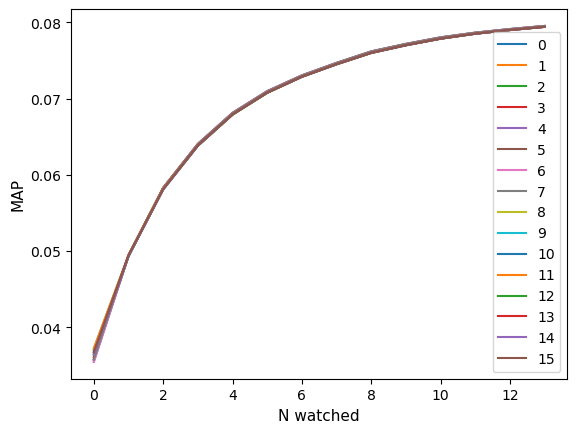

In [58]:
with open('watched_th_search_metrics_final.dill', 'rb') as f:
    t = dill.load(f)

in_users_splits = [
    'segm_custom',
    'segm_all',
    'segm_sex',
    'segm_kids'
]

out_of_users_splits = [
    'segm_age_rate',
    'segm_content_rate',
    'segm_age_and_content_rate',
    'segm_without'
]

splits_pairs = []

for inner_split in in_users_splits:    
    for outer_split in out_of_users_splits:
        splits_pairs.append((inner_split, outer_split))
     
    
def same_keys_q(k1, k2):
    return k1[0] == k2[0] and k1[1] == k2[1]
    

fig, ax = plt.subplots()

for i, sp in enumerate(splits_pairs):
    scores = np.array(list(map(
        lambda x: x[1],
        filter(lambda x: same_keys_q(x[0], sp), t.items())
    )))
    ax.plot(scores, label=i)

plt.xlabel('N watched', fontsize=11)
plt.ylabel('MAP', fontsize=11)
plt.legend()
plt.show()

Все разбиения дают примерно одинаковый эффект. Посмотрим, что будет, если всем рекомендовать популярное:

In [51]:
max_watched = train.groupby('user_id').count().max()['item_id'] + 1

base_estimator_kwargs = {
    'pop_items': items_pop_ordered
}
sub_est_predict_kwargs = {
    'complete_method': 'popular'
}

segment_knn = SegmentKNN(
    base_estimator=UserKnnComplete,
    sub_estimator=CosineRecommender,
    base_estimator_kwargs=base_estimator_kwargs,
    sub_estimators_predict_kwargs=sub_est_predict_kwargs
)

# current split (any possible)
base_estimator_fit_kwargs = {
    'user_segment_df': segment_users,
    'segm_col': 'segm_custom'
}

# init and fit popular wrapper

popular_wrapper = PopularWrapper(
    base_estimator=segment_knn,
    rec_pops=items_pop_ordered,
    threshold=max_watched,  # recommend popular to everyone
    base_estimator_fit_kwargs=base_estimator_fit_kwargs
)

popular_wrapper.fit(train)

# predict on test data

base_estimator_predict_kwargs = {
    'N_recs': 10
}

pop_wrapper_recs = pd.concat([
    popular_wrapper.predict(
        test.iloc[:69174],
        base_estimator_predict_kwargs
    ),
    popular_wrapper.predict(
        test.iloc[69174:138349],
        base_estimator_predict_kwargs
    ),
    popular_wrapper.predict(
        test.iloc[138349:207524],
        base_estimator_predict_kwargs
    ),
    popular_wrapper.predict(
        test.iloc[207524:],
        base_estimator_predict_kwargs
    )
])

# evaluate metric

pop_wrapper_map = metric.calc(pop_wrapper_recs, test)
pop_wrapper_map

0.08235218758429014

Выберем топ 4 лучших решений с kNN:

In [62]:
best_params = sorted(t.items(), key=lambda x: x[1], reverse=True)
best_params[:4]

[(('segm_all', 'segm_age_rate', 29), 0.07951781067528697),
 (('segm_all', 'segm_age_and_content_rate', 29), 0.07951353845635395),
 (('segm_all', 'segm_without', 29), 0.07951206369239931),
 (('segm_all', 'segm_content_rate', 29), 0.07950775890202572)]

Для данных решений посмотрим, можно ли улучшить качество отностиельно рекомендаций популярного всем подряд, при этом оставив относительно разумный порог по количеству просмотров контента.

In [26]:
in_users_splits = [
    'segm_all',
]

out_of_users_splits = [
    'segm_age_rate',
    'segm_content_rate',
    'segm_age_and_content_rate',
    'segm_without'
]

N_watched_tresholds = list(range(25, 55, 5))

N_neibhs = list(range(10, 80, 10))

total = (
    len(in_users_splits)
    * len(out_of_users_splits)
    * len(N_watched_tresholds)
    * len(N_neibhs)
)

results = {}
c = 0
for inner_split in in_users_splits:    
    for outer_split in out_of_users_splits:
        for watched_thershold in N_watched_tresholds:
            for N_neibh in N_neibhs:

                c += 1

                # skip
                r = (inner_split, outer_split, watched_thershold, N_neibh)
                if r in results.keys():
                    continue

                # join users splits
                split = join_user_splits(
                    segment_users, segm_train_out_users,
                    inner_split, outer_split
                )

                # init base estimator (segment knn)
                # for popular wrapper

                base_estimator_kwargs = {
                    'pop_items': items_pop_ordered,
                    'N_users': N_neibh  # current Nneibhs
                }
                sub_est_predict_kwargs = {
                    'complete_method': 'popular',

                }

                segment_knn = SegmentKNN(
                    base_estimator=UserKnnComplete,
                    sub_estimator=CosineRecommender,
                    base_estimator_kwargs=base_estimator_kwargs,
                    sub_estimators_predict_kwargs=sub_est_predict_kwargs
                )

                # current split
                base_estimator_fit_kwargs = {
                    'user_segment_df': split,
                    'segm_col': inner_split
                }

                # init and fit popular wrapper

                popular_wrapper = PopularWrapper(
                    base_estimator=segment_knn,
                    rec_pops=items_pop_ordered,
                    threshold=watched_thershold,  # current threshold
                    base_estimator_fit_kwargs=base_estimator_fit_kwargs
                )

                popular_wrapper.fit(train)

                # predict on test data

                base_estimator_predict_kwargs = {
                    'N_recs': 10
                }

                pop_wrapper_recs = pd.concat([
                    popular_wrapper.predict(
                        test.iloc[:69174],
                        base_estimator_predict_kwargs
                    ),
                    popular_wrapper.predict(
                        test.iloc[69174:138349],
                        base_estimator_predict_kwargs
                    ),
                    popular_wrapper.predict(
                        test.iloc[138349:207524],
                        base_estimator_predict_kwargs
                    ),
                    popular_wrapper.predict(
                        test.iloc[207524:],
                        base_estimator_predict_kwargs
                    )
                ])

                # evaluate metric

                pop_wrapper_map = metric.calc(pop_wrapper_recs, test)
                results[
                    (inner_split, outer_split, watched_thershold, N_neibh)
                ] = pop_wrapper_map

                with open(
                    'watched_th_and_Nneibhs_metrics.dill', 'wb') as f:
                    dill.dump(results, f)

                # stdout evaluation results:
                clear_output()
                print(f'{c}/{total}')
                print('-'*20)
                for k,v in results.items():
                    print(f'{k}: {round(v, 5)}')

168/168
--------------------
('segm_all', 'segm_age_rate', 25, 10): 0.07864
('segm_all', 'segm_age_rate', 25, 20): 0.07864
('segm_all', 'segm_age_rate', 25, 30): 0.07864
('segm_all', 'segm_age_rate', 25, 40): 0.07864
('segm_all', 'segm_age_rate', 25, 50): 0.07864
('segm_all', 'segm_age_rate', 25, 60): 0.07864
('segm_all', 'segm_age_rate', 25, 70): 0.07864
('segm_all', 'segm_age_rate', 30, 10): 0.07968
('segm_all', 'segm_age_rate', 30, 20): 0.07968
('segm_all', 'segm_age_rate', 30, 30): 0.07968
('segm_all', 'segm_age_rate', 30, 40): 0.07968
('segm_all', 'segm_age_rate', 30, 50): 0.07968
('segm_all', 'segm_age_rate', 30, 60): 0.07968
('segm_all', 'segm_age_rate', 30, 70): 0.07968
('segm_all', 'segm_age_rate', 35, 10): 0.08038
('segm_all', 'segm_age_rate', 35, 20): 0.08038
('segm_all', 'segm_age_rate', 35, 30): 0.08038
('segm_all', 'segm_age_rate', 35, 40): 0.08038
('segm_all', 'segm_age_rate', 35, 50): 0.08038
('segm_all', 'segm_age_rate', 35, 60): 0.08038
('segm_all', 'segm_age_rate', 3

In [22]:
# with open('watched_th_and_Nneibhs_metrics_final.dill', 'rb') as f:
#     u = dill.load(f)

Исходя из результатов перебора, количество соседей практически никак не влияет на результирующую метрику, оставим это значение равным $50$ (значение по умолчанию). Увеличение порога количества просмотров в свою очередь оказывает существенное влияние на метрику. Тем не менее не будем сильно завышать данный параметр и положим его равным $15$. Относительно данного параметра выберем наилучшее разбиение:

In [28]:
sorted(
    (filter(lambda x: x[0][2] == 15, t.items())),
    key=lambda x: x[1],
    reverse=True
)[0]

(('segm_all', 'segm_content_rate', 15), 0.07304300363872418)

Данные параметры будем использовать для результирующей модели на основе kNN.

# 4. Оптимизация модели для одного пользователя

По больщому счету нам необходимы только маппинги пользователей по сегментам и соответсвующие им модели. Для всех пользователей, которые в данные маппинги не попадают, рекомендациями будет популярное.

Обучим выбранную модель и сохраним все необходиоме.

In [73]:
# join users splits
split = join_user_splits(
    segment_users, segm_train_out_users,
    'segm_all', 'segm_content_rate'
)

watched_thershold = 15

# init base estimator (segment knn)
# for popular wrapper

base_estimator_kwargs = {
    'pop_items': items_pop_ordered,
}
sub_est_predict_kwargs = {
    'complete_method': 'popular',
}

segment_knn = SegmentKNN(
    base_estimator=UserKnnComplete,
    sub_estimator=CosineRecommender,
    base_estimator_kwargs=base_estimator_kwargs,
    sub_estimators_predict_kwargs=sub_est_predict_kwargs
)

# split
base_estimator_fit_kwargs = {
    'user_segment_df': split,
    'segm_col': 'segm_all'
}

# init and fit popular wrapper

popular_wrapper = PopularWrapper(
    base_estimator=segment_knn,
    rec_pops=items_pop_ordered,
    threshold=watched_thershold,
    base_estimator_fit_kwargs=base_estimator_fit_kwargs
)

popular_wrapper.fit(train)

  0%|          | 0/1372 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/2465 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/1634 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/1782 [00:00<?, ?it/s]

  0%|          | 0/1452 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/1103 [00:00<?, ?it/s]

  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1259 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/1094 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1864 [00:00<?, ?it/s]

  0%|          | 0/752 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2183 [00:00<?, ?it/s]

  0%|          | 0/728 [00:00<?, ?it/s]

  0%|          | 0/885 [00:00<?, ?it/s]

  0%|          | 0/304 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2502 [00:00<?, ?it/s]

  0%|          | 0/3710 [00:00<?, ?it/s]

  0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/1492 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1611 [00:00<?, ?it/s]

  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/801 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/764 [00:00<?, ?it/s]

  0%|          | 0/1137 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/1619 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2105 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1164 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8454 [00:00<?, ?it/s]

  0%|          | 0/1823 [00:00<?, ?it/s]

  0%|          | 0/1051 [00:00<?, ?it/s]

Маппинги пользователей:

In [74]:
popular_wrapper.base_estimator.users_segment_map

{216495: 7,
 515668: 7,
 306720: 7,
 555792: 7,
 1066967: 1,
 182442: 0,
 372268: 7,
 657798: 7,
 505924: 6,
 19772: 0,
 621344: 7,
 1011510: 7,
 519719: 7,
 753791: 7,
 85214: 7,
 485652: 7,
 656295: 1,
 579268: 7,
 886671: 7,
 1068489: 7,
 844373: 1,
 516186: 1,
 879632: 7,
 929627: 1,
 15157: 1,
 513749: 7,
 569584: 7,
 778000: 7,
 384896: 6,
 777240: 7,
 996197: 7,
 964307: 1,
 548757: 7,
 80568: 1,
 964820: 7,
 735611: 7,
 810485: 7,
 378651: 1,
 503790: 7,
 156939: 7,
 173046: 7,
 608108: 7,
 926953: 7,
 358542: 7,
 794054: 7,
 813535: 7,
 64739: 7,
 157555: 1,
 163322: 1,
 407397: 7,
 963906: 7,
 147041: 7,
 782894: 7,
 837382: 1,
 880906: 1,
 1041354: 7,
 530707: 7,
 255957: 1,
 318819: 1,
 1034112: 7,
 1055086: 1,
 139053: 1,
 665074: 1,
 14046: 7,
 93102: 1,
 43969: 7,
 322823: 1,
 619935: 7,
 656216: 7,
 470766: 1,
 932336: 7,
 277690: 7,
 225996: 1,
 694850: 7,
 946187: 1,
 1079639: 1,
 358256: 0,
 116523: 7,
 158490: 1,
 968761: 7,
 986283: 1,
 587163: 1,
 279758: 1,
 5130

In [75]:
with open('users_segment_map.dill', 'wb') as f:
    dill.dump(popular_wrapper.base_estimator.users_segment_map, f)

Маппинги моделей:

In [76]:
popular_wrapper.base_estimator.sub_estimators

{1: <__main__.UserKnnComplete at 0x7f517cb83040>,
 6: <__main__.UserKnnComplete at 0x7f5196bb8100>,
 7: <__main__.UserKnnComplete at 0x7f51ad53bbb0>,
 0: <__main__.UserKnnComplete at 0x7f51650fcdc0>,
 8: <__main__.UserKnnComplete at 0x7f5196bb85e0>,
 9: <__main__.UserKnnComplete at 0x7f5196bb81c0>,
 2: <__main__.UserKnnComplete at 0x7f5196718070>,
 3: <__main__.UserKnnComplete at 0x7f5196bb87f0>,
 11: <__main__.UserKnnComplete at 0x7f518374f8e0>,
 10: <__main__.UserKnnComplete at 0x7f517e0e7d00>,
 5: <__main__.UserKnnComplete at 0x7f51874cd070>,
 13: <__main__.UserKnnComplete at 0x7f517c3bcd00>,
 19: <__main__.UserKnnComplete at 0x7f5196b75f40>,
 12: <__main__.UserKnnComplete at 0x7f517c3bcca0>,
 18: <__main__.UserKnnComplete at 0x7f51889baa60>,
 21: <__main__.UserKnnComplete at 0x7f51650bd8b0>,
 14: <__main__.UserKnnComplete at 0x7f5161da4df0>,
 20: <__main__.UserKnnComplete at 0x7f51889a2c40>,
 15: <__main__.UserKnnComplete at 0x7f51889a2e20>,
 17: <__main__.UserKnnComplete at 0x7f51

In [77]:
with open('segment_model_map.dill', 'wb') as f:
    dill.dump(popular_wrapper.base_estimator.sub_estimators, f)

In [78]:
with open('warmup_users.dill', 'wb') as f:
    dill.dump(train['user_id'].unique().tolist()[:100000], f)

Популярное:

In [121]:
from typing import List, Tuple


class BaseModel:
    def __init__(self, model_name: str):
        self.model_name = model_name


class KNNModel(BaseModel):
    model_name = 'knn_model'
    
    def __init__(
        self,
        user_segment_map: dict,
        segment_model_map: dict,
        pop_items: List[int],
    ):
        super().__init__(self.model_name)
        self.user_segment_map = user_segment_map
        self.segment_model_map = segment_model_map
        self.pop_items = pop_items
        
    def predict(self, user_id: int, k:int) -> List[int]:
        user_segment = self.user_segment_map.get(user_id)
        if user_segment is None:
            return self._predict_popular(k)
        else:
            return self._predict_by_model(user_id, user_segment, k)
        
    def _predict_popular(self, k: int) -> List[int]:
        return self.pop_items[:k].tolist()
        
    def _get_similar_users(
        self,
        user_id: int,
        user_segment: int,
    ) -> Tuple[List[int], List[float]]:
        # take segment model:
        model = self.segment_model_map[user_segment]
        # find similar users:
        inner_user_id = model.users_mapping[user_id]
        sim = list(filter(
            lambda x: x[1] < 1,
            model.user_knn.similar_items(
                inner_user_id,
                N=model.N_users
            )[1:] # exclude same user
        ))
        return (
            [model.users_inv_mapping[user] for user, _ in sim],
            [user_s for _, user_s in sim]
        )
        
    def _predict_by_model(
        self,
        user_id: int,
        user_segment: int,
        k: int
    ) -> List[int]:
        # get similar users (ids and scores):
        sim_users, sim_score = self._get_similar_users(
            user_id, user_segment
        )
        # prepare df to sort items of similar users:
        model = self.segment_model_map[user_segment]
        sim_users_items = model.watched.loc[sim_users]
        sim_users_items['sim'] = sim_score
        # evaluate score:
        sim_users_items = (
            # items of similar users:
            sim_users_items
            .explode('item_id')
            .reset_index()
            .rename(columns={'user_id': 'sim_user_id'})
            .drop_duplicates(['item_id'],keep='first')
            # idf of items of similar users:
            .merge(
                model.item_idf,
                left_on='item_id',
                right_on='index',
                how='left'
            )
        )
        # final score:
        sim_users_items['score'] = (
            sim_users_items['sim'] * sim_users_items['idf']
        )
        # sort by score:
        sim_users_items = (
            sim_users_items.sort_values(['score'], ascending=False)
        )
        recs = sim_users_items['item_id'].iloc[:k].tolist()
        # complete with popular:
        if len(recs) < k:
            pop = list(filter(
                lambda x: x not in recs,
                self._predict_popular(k)
            ))
            recs = (recs + pop)[:k]
        return recs
    
    def warmup(self, users_ids: List[int]) -> None:
        for user_id in tqdm(users_ids):
            self.predict(user_id, k=10)
    

def read_dill(filepath: str):
    with open(filepath, 'rb') as f:
        data = dill.load(f)
    return data


class KNNModelConfig:
    def __init__(
        self,
        users_segment_map_path: str,
        sub_estimators_path: str,
        items_pop_ordered_path: str,
        warmup_users_path: str = None
    ):
        self.users_segment_map_path = users_segment_map_path
        self.sub_estimators_path = sub_estimators_path
        self.items_pop_ordered_path = items_pop_ordered_path
        self.warmup_users_path = warmup_users_path
        
        self.users_segment_map = None,
        self.sub_estimators = None,
        self.items_pop_ordered = None
        self.warmup_users = None
    
    def parse(self):
        self.users_segment_map = read_dill(
            self.users_segment_map_path
        )
        self.sub_estimators = read_dill(
            self.sub_estimators_path
        )
        self.items_pop_ordered = read_dill(
            self.items_pop_ordered_path
        )
        if self.warmup_users_path is not None:
            self.warmup_users = read_dill(
                self.warmup_users_path
            )

            
class KNNModelInitializer:
    def __init__(
        self,
        config: KNNModelConfig,
    ):
        self.config = config
        
    def init_model(self):
        self.config.parse()
        model = KNNModel(
            user_segment_map=self.config.users_segment_map,
            segment_model_map=self.config.sub_estimators,
            pop_items=self.config.items_pop_ordered
        )
        if self.config.warmup_users is not None:
            model.warmup(self.config.warmup_users)
        return model

In [122]:
knn_model_config = KNNModelConfig(
    users_segment_map_path = 'users_segment_map.dill',
    sub_estimators_path = 'segment_model_map.dill',
    items_pop_ordered_path = 'items_pop_ordered.dill',
    warmup_users_path = None  # 'warmup_users.dill' 
)

knn_model_initializer = KNNModelInitializer(knn_model_config)

test_knn_model = knn_model_initializer.init_model()

In [123]:
test_knn_model.predict(1, 10)

[10440, 15297, 9728, 13865, 4151, 3734, 2657, 4880, 142, 6809]

In [124]:
test_knn_model.predict(382508, 10)

[10440, 15297, 9728, 13865, 4151, 3734, 2657, 4880, 142, 6809]

In [125]:
test_knn_model.predict(1097470, 10)

[5438, 3306, 1193, 12596, 2356, 11004, 10506, 3959, 10287, 2169]

In [126]:
test_knn_model.predict(241, 10)

[2650, 5114, 9961, 5589, 7440, 7053, 14841, 615, 12846, 13023]

# Резюме

Была побита метрика на лидерборде. Наша модель показывает качество $0.085$.

Было реализовано дополнение количества рекомендаций до $N$.

Проведен подбор множетсва различных гиперпараметров:
* Несколько видов сегментации пользователей
* Количество соседей
* Порог количества просмотренных картин в контексте сегментации холодных пользователей
* Различные knn модели (без дополнения, с дополнением, по различным сегментам)
* Также для реализации сегментации всех теплых пользователей был применен метод заполнения пропущенных значений MissForest

Все подборы гиперпараметров основывались на офлайн валидации на разделенной выборке.

Было рализовано покрытие холодных пользователей рекомендациями популярных айтемов.

Был реализован блендинг моделей подбора айтемов:
* Первичное выделение айтемов путем кластеризации пользователей на сегменты
* Уточнение айтемов knn моделью по соответсвующему сегменту

Модель была оптимизирована для внедрения в сервис. Предсказания строятся для одного пользователя за раз. Инициализация модели заключается в подгрузке соответсвующих маппингов пользователей на сегменты и моделей по сегментам. Был реализован онлайн формат выдачи рекомендаций ("на лету").